# Human Activity Recognition 
### Udacity Machine Learning Nanodegree, Capstone Project
#### Glenn Mossy 12/20/2019

This project explores a readily available dataset from the UCI [1] that is based on the work "Human Activity Recognition on Smartphones With Awareness of Basic Activities and Postural Transitions", by Jorge-Luis Reyes-Ortiz, Luca Oneto, Alessandro Ghio, Albert SamÃ¡, Davide Anguita and Xavier Parra. This work expands on the earlier work done [2] "A Public Domain Dataset for Human Activity Recognition Using Smartphones." by adding a study of Postual Transitions. In this project I build several machine learning models to train and predict the human activities such as walking, walking upstairs, walking downstairs, sitting, standing, or laying along with postural transitions from one of standing, sitting or laying postions and of thier opposites. Accuracy scoring and analysis will be done on the performance of each of the models.

This dataset was collected from 30 subjects performing different activities with a smartphone attached to their body. The data is recorded with the help of sensors (accelerometer and Gyroscope) in the smartphone being carried. 

By using the sensors(Gyroscope and accelerometer) in a smartphone, the data captured '3-axial linear acceleration'(tAcc-XYZ) from accelerometer and '3-axial angular velocity' (tGyro-XYZ) from Gyroscope with several variations. The prefix 't' in those metrics denotes time.

The suffix 'XYZ' represents 3-axial signals in X , Y, and Z directions.

The data we will be using is the Human Activity Recognition dataset from the UCI Machine Learning Repository: 
Version 2 of the dataset:
http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions


### Feature Names

The sensor signals were preprocessed by applying noise filters and then sampled in fixed-width windows(sliding windows) of 2.56 seconds each with 50% overlap. ie., each window has 128 readings.
Then from Each window, a feature vector was obtianed by calculating variables from the time and frequency domain.

The acceleration signal was separated into Body and Gravity acceleration signals(tBodyAcc-XYZ and tGravityAcc-XYZ) using a low pass filter with corner frequecy of 0.3Hz.  The body linear acceleration and angular velocity were derived in time to obtain the jerk signals (tBodyAccJerk-XYZ and tBodyGyroJerk-XYZ).
The magnitude of these 3-dimensional signals were calculated using the Euclidian norm. This magnitudes are represented as features with names like tBodyAccMag, tGravityAccMag, tBodyAccJerkMag, tBodyGyroMag and tBodyGyroJerkMag.

Then frequency domain signals from some of the available signals were obtained by applying a FFT (Fast Fourier Transform). These signals obtained were labeled with prefix 'f' just like original signals with prefix 't'. These signals are labeled as fBodyAcc-XYZ, fBodyGyroMag.


## Importing the libraries

In [153]:
# Importing the os, math and visualization libraries
import os
import time
import numpy as np
import pandas as pd
import pickle, gzip
# Data Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Importing sklearn models and metrics

In [154]:
# Imports some of the preprocessing libraries
from sklearn import preprocessing as pp 
from sklearn.preprocessing import LabelEncoder

In [155]:
# Import some of the model libraries and metrics support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  GradientBoostingClassifier 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.metrics import precision_recall_fscore_support as error_metric
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
# from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.feature_selection import VarianceThreshold
#from sklearn.metrics import *

## Import the TensorFlow and keras models and components

In [156]:
'''TensorFlow and Keras'''
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda, Activation
from keras import regularizers
from keras.losses import mse, binary_crossentropy
import tensorflow as tf

### Load and prepare the Training, and Test Data, Activties and features

In [157]:
#  Smartphone-Based Recognition of Human Activities and Postural Transitions Data Set
#  Activity recognition data set built from the recordings of 30 subjects performing basic activities and postural transitions while carrying a waist-mounted smartphone with embedded inertial sensors.
# http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions
# Updated Version of the dataset that adds postural transitions
# http://archive.ics.uci.edu/ml/machine-learning-databases/00341/ in a folder callled "HAPT Data Set"
# './data/HAPT Data Set/Train/subject_id_train.txt'
# './data/HAPT Data Set/Train/X_train.txt'
# './data/HAPT Data Set/Train/y_train.txt'
# './data/HAPT Data Set/activity_labels'
# './data/HAPT Data Set/features'
# './data/HAPT Data Set/activity_labels'
# './data/HAPT Data Set/features_info'

print('get the data from the following txt files into pandas dataframes') 
print(os.listdir('./data/HAPT Data Set'))

# The Training set
X_train2 = pd.read_csv('./data/HAPT Data Set/Train/X_train.txt', sep='\s+', header=None)
# The Training labels
y_train2 = pd.read_csv('./data/HAPT Data Set/Train/y_train.txt', sep='\s+', header=None, names='Y')
# y_train2 = pd.read_csv('./data/HAPT Data Set/Train/y_train.txt', sep='\s+', header=None, names='Activity')
# The Test set.
X_test2 = pd.read_csv('./data/HAPT Data Set/Test/X_test.txt', sep='\s+', header=None)
# The Test set labels
y_test2 = pd.read_csv('./data/HAPT Data Set/Test/y_test.txt', sep='\s+', header=None, names='Y')

#  Each row identifies the subject who performed the activity for each window sample. Its range is from 1 to 30. 
subject_train2 = pd.read_csv('./data/HAPT Data Set/Train/subject_id_train.txt', sep='\s+', header=None)

# Each row identifies the subject who performed the activity for each window sample. Its range is from 1 to 30. 
subject_test2 = pd.read_csv('./data/HAPT Data Set/Test/subject_id_test.txt', sep='\s+', header=None)

# 'features.txt': List of all features.
features2 = pd.read_csv('./data/HAPT Data Set/features.txt', header=None)

#'features_info.txt': Shows information about the variables used on the feature vector.

# 'activity_labels.txt': Links the class labels with their activity name.
activity_labels2 = pd.read_csv('./data/HAPT Data Set/activity_labels.txt', sep='\s+', names=('ID', 'Activity'), header=None)

# combine the train/test data
X = pd.concat([X_train2, X_test2])
y = pd.concat([y_train2, y_test2])

# The following files are available for the train and test data. Their descriptions are equivalent.
# - 'train/subject_train.txt': Each row identifies the subject who performed the activity for each window sample. Its range is from 1 to 30. 
# - 'train/Inertial Signals/total_acc_x_train.txt': The acceleration signal from the smartphone accelerometer X axis in standard gravity units 'g'. 
#  Every row shows a 128 element vector. The same description applies for the 'total_acc_x_train.txt' and 'total_acc_z_train.txt' files for the Y and Z axis. 
# - 'train/Inertial Signals/body_acc_x_train.txt': The body acceleration signal obtained by subtracting the gravity from the total acceleration. 
# - 'train/Inertial Signals/body_gyro_x_train.txt': The angular velocity vector measured by the gyroscope for each window sample. The units are radians/second. 

# Inertial Signals
total_acc_x_train = pd.read_csv('./data/UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt', sep='\s+', header=None)
# body_acc_x_train = pd.read_csv('./data/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt', sep='\s+', header=None)
# body_gyro_x_train = pd.read_csv('./data/UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt', sep='\s+', header=None)

INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

get the data from the following txt files into pandas dataframes
['activity_labels.txt', 'features.txt', 'features_info.txt', 'human_activity_predictions.csv', 'RawData', 'README.txt', 'Test', 'Train']


## Data Cleaning

### 1.  Check for Duplicates

In [158]:
print('No of duplicates in train: {}'.format(sum(X_train2.duplicated())))
print('No of duplicates in test : {}'.format(sum(X_test2.duplicated())))

No of duplicates in train: 0
No of duplicates in test : 0


### 2.  Check for NaN/null Values

In [159]:
# Check for null values
print('We have {} NaN/Null values in train'.format(X_train2.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(X_test2.isnull().values.sum()))

We have 0 NaN/Null values in train
We have 0 NaN/Null values in test


### 3.  Statistics about the dataset

In [160]:
# Here we print some information about the dataset
print('Get the data and statistics from the following txt files into pandas dataframes') 
print(os.listdir('./data/HAPT Data Set'))
print ('')
print ('The training set has {} samples'.format(len(X_train2)))
print ('The testing set has  {} samples'.format(len(X_test2)))
print ('')
print ('The readings of the test subjects are already split into a training dataset and test dataset:')
print ('The percentage of training total samples is {:.2f}%'.format(len(X_train2) / float(len(X_test2) + len(X_train2)) * 100))
print ('The percentage of test total samples is {:.2f}%'.format(len(X_test2) / float(len(X_test2) + len(X_train2)) * 100))
print ('')
print ('The shape of the training set dataframe is {} '.format(X_train2.shape))
print ('The shape of the training set labels dataframe is {} '.format(y_train2.shape))
print ('')
print ('The shape of the testing set dataframe is {} '.format(X_test2.shape))
print ('The shape of the test set labels dataframe is {} '.format(y_test2.shape))
print ('')
print (f'The Number of Inertial Signal features in the dataset is = {len(X_train2.columns)}')

print('')
print('Accelerometer and Gyroscope readings are taken from 30 volunteers while performing the following {} Activities:'.format(len(activity_labels2.Activity)))
print (f'Activity Labels: {activity_labels2.Activity.unique()}')
print (f'The Number of activities is = {len(activity_labels2.Activity)}')
print('')
print ('The test data set has {} samples and each datapoint corresponds to one of the Activities.'.format(len(subject_test2)))
print('')
print (f'Info about the training dataset = {X_train2.info()}')
print (f'Info about the testing dataset = {X_test2.info()}')


Get the data and statistics from the following txt files into pandas dataframes
['activity_labels.txt', 'features.txt', 'features_info.txt', 'human_activity_predictions.csv', 'RawData', 'README.txt', 'Test', 'Train']

The training set has 7767 samples
The testing set has  3162 samples

The readings of the test subjects are already split into a training dataset and test dataset:
The percentage of training total samples is 71.07%
The percentage of test total samples is 28.93%

The shape of the training set dataframe is (7767, 561) 
The shape of the training set labels dataframe is (7767, 1) 

The shape of the testing set dataframe is (3162, 561) 
The shape of the test set labels dataframe is (3162, 1) 

The Number of Inertial Signal features in the dataset is = 561

Accelerometer and Gyroscope readings are taken from 30 volunteers while performing the following 12 Activities:
Activity Labels: ['WALKING' 'WALKING_UPSTAIRS' 'WALKING_DOWNSTAIRS' 'SITTING' 'STANDING'
 'LAYING' 'STAND_TO_SIT'

In [161]:
features2.describe()

,0
count,561
unique,533
top,tBodyAcc-ropy-1
freq,3


Below are the properties of the signal samples for the train dataset and the the test dataset:  Mean value, standard deviation, Quartile values, and Maximum. 

In [162]:
X_train2.describe()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,...,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000
mean,0.038759,-0.000647,-0.018155,-0.599017,-0.634424,-0.691270,-0.623886,-0.657884,-0.740154,-0.360200,...,0.161745,-0.316548,-0.625132,0.016774,0.018471,0.009239,-0.005184,-0.485936,0.050310,-0.052888
std,0.101996,0.099974,0.089927,0.441481,0.367558,0.321641,0.418113,0.348005,0.272619,0.499259,...,0.237319,0.313899,0.302581,0.331326,0.443540,0.601208,0.477218,0.509278,0.300866,0.276196
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.958535,-1.000000,-1.000000,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.987874
25%,0.032037,-0.011209,-0.028448,-0.992140,-0.983570,-0.984661,-0.992902,-0.984131,-0.986661,-0.795613,...,0.020312,-0.548129,-0.843966,-0.108225,-0.261002,-0.470267,-0.373565,-0.810953,-0.047752,-0.140560
50%,0.038975,-0.002921,-0.019602,-0.914202,-0.827970,-0.827696,-0.924421,-0.838559,-0.852735,-0.717007,...,0.170819,-0.353980,-0.710071,0.017627,0.029079,0.001515,-0.005503,-0.706619,0.176777,0.004583
75%,0.044000,0.004303,-0.011676,-0.246026,-0.313069,-0.450478,-0.294903,-0.362671,-0.540521,0.054178,...,0.316240,-0.137462,-0.503837,0.167695,0.314876,0.496871,0.352690,-0.488765,0.246834,0.109507
max,1.000000,1.000000,1.000000,1.000000,0.945956,1.000000,1.000000,0.960341,1.000000,1.000000,...,1.000000,0.938491,0.911653,1.000000,1.000000,0.998702,0.991288,1.000000,0.482229,1.000000


In [163]:
X_test2.describe()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,...,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000
mean,0.040530,-0.001695,-0.019453,-0.609770,-0.631731,-0.711263,-0.636741,-0.654112,-0.758061,-0.358429,...,0.162821,-0.284730,-0.595537,0.015090,0.021202,0.043183,-0.020684,-0.511371,0.067774,-0.045618
std,0.101559,0.102384,0.083897,0.405103,0.360294,0.284112,0.379665,0.342661,0.241093,0.479339,...,0.221286,0.313079,0.309507,0.329827,0.442320,0.626639,0.501336,0.506231,0.326118,0.239647
min,-0.751552,-0.962639,-0.814359,-0.999715,-0.999611,-0.999911,-0.999274,-0.999319,-0.999505,-0.893297,...,-1.000000,-0.997185,-0.985065,-1.000000,-0.993402,-0.998898,-0.990616,-0.983811,-0.914248,-1.000000
25%,0.031544,-0.011462,-0.028986,-0.990017,-0.979300,-0.981256,-0.991374,-0.980940,-0.983562,-0.793628,...,0.029500,-0.522444,-0.828862,-0.111039,-0.252667,-0.493294,-0.438279,-0.828871,-0.007741,-0.096185
50%,0.038861,-0.002700,-0.019488,-0.807078,-0.686914,-0.738534,-0.828256,-0.707638,-0.778504,-0.673711,...,0.176792,-0.322259,-0.681600,0.013685,0.032937,0.043555,-0.022624,-0.728029,0.175138,-0.005486
75%,0.043751,0.005224,-0.011233,-0.270904,-0.358639,-0.487716,-0.324933,-0.403433,-0.578883,0.052758,...,0.313719,-0.095637,-0.452381,0.161560,0.316195,0.609499,0.387438,-0.528704,0.257544,0.094051
max,0.976950,0.989925,0.766017,0.465271,1.000000,0.848957,0.439686,1.000000,0.689027,0.909166,...,0.984200,1.000000,1.000000,0.998898,0.986347,1.000000,1.000000,0.829446,1.000000,0.972160


In [164]:
# The subject (the volunteer who performed the test in the lab) column will be required for the samples by activity chart.
# add subject column to the dataframe
X_train2['subject'] = pd.read_csv('./data/HAPT Data Set/Train/subject_id_train.txt', sep='\s+', header=None)
# add subject column to the dataframe
X_test2['subject'] = pd.read_csv('./data/HAPT Data Set/Test/subject_id_test.txt', sep='\s+', header=None)

In [165]:
X_train2

,0,1,2,3,4,5,6,7,8,9,...,552,553,554,555,556,557,558,559,560,subject
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.314848,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718,1
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,-0.603199,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436,1
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,-0.404427,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271,1
3,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,-0.798477,...,-0.138373,-0.491604,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826,1
4,0.038758,-0.002289,-0.023863,-0.998241,-0.986774,-0.993115,-0.998216,-0.986479,-0.993825,-0.801982,...,-0.366214,-0.702490,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7762,0.048048,-0.042445,-0.065884,-0.195448,-0.278326,-0.219954,-0.282233,-0.305861,-0.357803,0.267874,...,-0.596760,-0.879026,-0.190437,0.829718,0.206972,-0.425619,-0.792292,0.238580,0.056020,30
7763,0.037639,0.006430,-0.044345,-0.235372,-0.302680,-0.232843,-0.322483,-0.354464,-0.345592,0.181271,...,-0.404418,-0.684496,0.064907,0.875679,-0.879033,0.400219,-0.772288,0.252653,0.056252,30
7764,0.037451,-0.002724,0.021009,-0.218281,-0.378082,-0.076950,-0.304446,-0.400661,-0.193071,0.113141,...,0.000207,-0.317314,0.052806,-0.266724,0.864404,0.701169,-0.779566,0.249121,0.047071,30
7765,0.044011,-0.004536,-0.051242,-0.219202,-0.383350,-0.081035,-0.310419,-0.380233,-0.201007,0.166671,...,0.037919,-0.356579,-0.101360,0.700740,0.936674,-0.589479,-0.785603,0.246409,0.031700,30


In [166]:
df=pd.DataFrame(subject_train2)
df.T

,0,1,2,3,4,5,6,7,8,9,...,7757,7758,7759,7760,7761,7762,7763,7764,7765,7766
0,1,1,1,1,1,1,1,1,1,1,...,30,30,30,30,30,30,30,30,30,30


In [167]:
# https://www.tutorialspoint.com/python_pandas/python_pandas_dataframe.htm
df=pd.DataFrame(features2)

In [168]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,fBodyGyroJerkMag-MeanFreq-1,fBodyGyroJerkMag-Skewness-1,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1


In [169]:
# Join Activity column to the dataframe (right) and copy to a new dataframe
# Activity column will be required for the samples by activity chart.
X_train2['Activity'] = y_train2
XA_train = X_train2['Activity'] = y_train2
# Join Activity column to the dataframe (right) and copy to a new dataframe
XA_test = X_test2['Activity'] = y_test2

In [170]:
XA_train.sample()

,Y
3936,6


In [171]:
XA_test.sample()

,Y
199,5


In [172]:
# samples of subject #30 where data is labeled #12 activity LIE_TO_STAND and copy to a new dataframe
# this dataframe now has an Activity and a Subject column.
XAS_train = X_train2[(X_train2['subject']=='30')|(X_train2['Activity']==12)]
XAS_test = X_test2[(X_test2['subject']=='30')|(X_test2['Activity']==12)]

In [173]:
XAS_train.sample()

,0,1,2,3,4,5,6,7,8,9,...,553,554,555,556,557,558,559,560,subject,Activity
5699,0.781347,-0.413755,-0.337024,-0.561161,-0.105671,-0.340838,-0.559077,-0.069085,-0.402824,0.013555,...,-0.755627,0.201683,0.554782,-0.135729,-0.557348,0.33735,-0.800107,-0.084939,25,12


In [174]:
XAS_test.sample()

,0,1,2,3,4,5,6,7,8,9,...,553,554,555,556,557,558,559,560,subject,Activity
1893,0.553514,-0.962639,-0.119182,-0.33994,-0.334327,0.053769,-0.328477,-0.312393,-0.09554,-0.090503,...,-0.201471,0.116542,0.292129,0.159196,0.326298,-0.291092,-0.362938,0.181184,13,12


In [175]:
df_train2 = pd.DataFrame(X_train2['Activity'])
df_train2

,Activity
0,5
1,5
2,5
3,5
4,5
...,...
7762,2
7763,2
7764,2
7765,2


### 4. Listing the activities dataset

In [176]:
# The activities
activity_labels2.Activity

0                WALKING
1       WALKING_UPSTAIRS
2     WALKING_DOWNSTAIRS
3                SITTING
4               STANDING
5                 LAYING
6           STAND_TO_SIT
7           SIT_TO_STAND
8             SIT_TO_LIE
9             LIE_TO_SIT
10          STAND_TO_LIE
11          LIE_TO_STAND
Name: Activity, dtype: object

In [177]:
# Put text labels in place of activity numbers on dataset
labeled_X_train2 = X_train2.replace({ 1: activity_labels2.Activity[0], 2: activity_labels2.Activity[1], 3: activity_labels2.Activity[2], 4: activity_labels2.Activity[3], 5: activity_labels2.Activity[4], 6: activity_labels2.Activity[5], 7: activity_labels2.Activity[6], 8: activity_labels2.Activity[7], 9: activity_labels2.Activity[8], 10: activity_labels2.Activity[9], 11: activity_labels2.Activity[10], 12: activity_labels2.Activity[11]})

In [178]:
# Put text labels in place of activity numbers on dataset
labeled_X_test2 = X_test2.replace({ 1: activity_labels2.Activity[0], 2: activity_labels2.Activity[1], 3: activity_labels2.Activity[2], 4: activity_labels2.Activity[3], 5: activity_labels2.Activity[4], 6: activity_labels2.Activity[5], 7: activity_labels2.Activity[6], 8: activity_labels2.Activity[7], 9: activity_labels2.Activity[8], 10: activity_labels2.Activity[9], 11: activity_labels2.Activity[10], 12: activity_labels2.Activity[11]})

In [179]:
labeled_X_train2.sample()

,0,1,2,3,4,5,6,7,8,9,...,553,554,555,556,557,558,559,560,subject,Activity
5599,0.0389934,-0.003058,-0.0170185,-0.998364,-0.987099,-0.991561,-0.997988,-0.987674,-0.992488,-0.803,...,-0.890158,-0.0160745,-0.0958833,0.314122,-0.316268,-0.841752,0.190729,-0.0365322,25,STANDING


In [180]:
labeled_X_test2.sample()

,0,1,2,3,4,5,6,7,8,9,...,553,554,555,556,557,558,559,560,subject,Activity
2849,0.0399487,-0.000775327,-0.0169043,-0.995324,-0.991446,-0.98904,-0.995562,-0.991637,-0.990005,-0.7944,...,-0.903089,-0.193768,-0.685437,0.0300523,-0.233484,-0.874797,0.00807753,0.0334947,24,SITTING


In [181]:
# The activities in the dataset as integers, i.e, 5= LAYING
df=pd.DataFrame(y_train2.Y)
df.T

,0,1,2,3,4,5,6,7,8,9,...,7757,7758,7759,7760,7761,7762,7763,7764,7765,7766
Y,5,5,5,5,5,5,5,5,5,5,...,2,2,2,2,2,2,2,2,2,2


In [182]:
# look at data as numpy array
X_train2.values

array([[ 4.35796737e-02, -5.97022125e-03, -3.50543440e-02, ...,
        -5.17184161e-02,  1.00000000e+00,  5.00000000e+00],
       [ 3.94800368e-02, -2.13127573e-03, -2.90673617e-02, ...,
        -4.74363375e-02,  1.00000000e+00,  5.00000000e+00],
       [ 3.99777809e-02, -5.15271611e-03, -2.26507084e-02, ...,
        -4.22713632e-02,  1.00000000e+00,  5.00000000e+00],
       ...,
       [ 3.74509378e-02, -2.72442363e-03,  2.10094076e-02, ...,
         4.70707709e-02,  3.00000000e+01,  2.00000000e+00],
       [ 4.40110453e-02, -4.53578080e-03, -5.12422044e-02, ...,
         3.17000286e-02,  3.00000000e+01,  2.00000000e+00],
       [ 6.89537649e-02,  1.81032226e-03, -8.03234315e-02, ...,
         4.29812890e-02,  3.00000000e+01,  2.00000000e+00]])

In [183]:
labeled_y_train2 = df.replace({ 1: activity_labels2.Activity[0], 2: activity_labels2.Activity[1], 3: activity_labels2.Activity[2], 4: activity_labels2.Activity[3], 5: activity_labels2.Activity[4], 6: activity_labels2.Activity[5], 7: activity_labels2.Activity[6], 8: activity_labels2.Activity[7], 9: activity_labels2.Activity[8], 10: activity_labels2.Activity[9], 11: activity_labels2.Activity[10], 12: activity_labels2.Activity[11]})

In [184]:
# https://www.tutorialspoint.com/python_pandas/python_pandas_dataframe.htm
labeled_y_train2['Y'].value_counts()

STANDING              1423
LAYING                1413
SITTING               1293
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     987
STAND_TO_LIE            90
SIT_TO_LIE              75
LIE_TO_SIT              60
LIE_TO_STAND            57
STAND_TO_SIT            47
SIT_TO_STAND            23
Name: Y, dtype: int64

In [185]:
print('Train labels', activity_labels2['Activity'], y_train2["Y"])

Train labels 0                WALKING
1       WALKING_UPSTAIRS
2     WALKING_DOWNSTAIRS
3                SITTING
4               STANDING
5                 LAYING
6           STAND_TO_SIT
7           SIT_TO_STAND
8             SIT_TO_LIE
9             LIE_TO_SIT
10          STAND_TO_LIE
11          LIE_TO_STAND
Name: Activity, dtype: object 0       5
1       5
2       5
3       5
4       5
       ..
7762    2
7763    2
7764    2
7765    2
7766    2
Name: Y, Length: 7767, dtype: int64


In [186]:
df = X_train2
test = X_test2

In [187]:
y_train2.columns

Index(['Y'], dtype='object')

In [188]:
X_train2

,0,1,2,3,4,5,6,7,8,9,...,553,554,555,556,557,558,559,560,subject,Activity
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718,1,5
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436,1,5
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271,1,5
3,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,-0.798477,...,-0.491604,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826,1,5
4,0.038758,-0.002289,-0.023863,-0.998241,-0.986774,-0.993115,-0.998216,-0.986479,-0.993825,-0.801982,...,-0.702490,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7762,0.048048,-0.042445,-0.065884,-0.195448,-0.278326,-0.219954,-0.282233,-0.305861,-0.357803,0.267874,...,-0.879026,-0.190437,0.829718,0.206972,-0.425619,-0.792292,0.238580,0.056020,30,2
7763,0.037639,0.006430,-0.044345,-0.235372,-0.302680,-0.232843,-0.322483,-0.354464,-0.345592,0.181271,...,-0.684496,0.064907,0.875679,-0.879033,0.400219,-0.772288,0.252653,0.056252,30,2
7764,0.037451,-0.002724,0.021009,-0.218281,-0.378082,-0.076950,-0.304446,-0.400661,-0.193071,0.113141,...,-0.317314,0.052806,-0.266724,0.864404,0.701169,-0.779566,0.249121,0.047071,30,2
7765,0.044011,-0.004536,-0.051242,-0.219202,-0.383350,-0.081035,-0.310419,-0.380233,-0.201007,0.166671,...,-0.356579,-0.101360,0.700740,0.936674,-0.589479,-0.785603,0.246409,0.031700,30,2


### 5. Plot of the samples by Activities, and by Test Subject (human)

----------------------------------------
STANDING              1423
LAYING                1413
SITTING               1293
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     987
STAND_TO_LIE            90
SIT_TO_LIE              75
LIE_TO_SIT              60
LIE_TO_STAND            57
STAND_TO_SIT            47
SIT_TO_STAND            23
Name: Y, dtype: int64
----------------------------------------


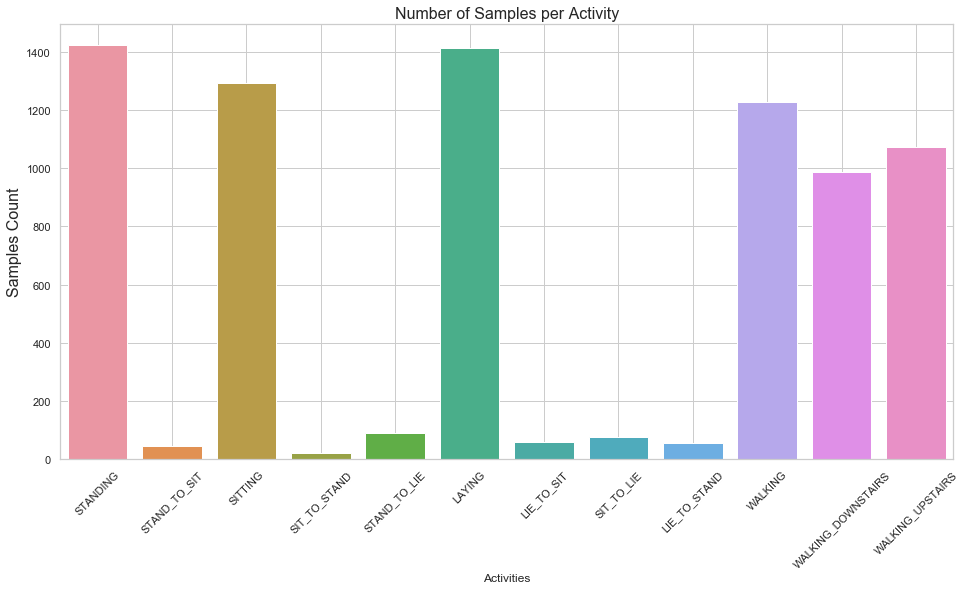

In [189]:
df = labeled_y_train2

df.T
# print(df.Y.unique())
print("----------------------------------------")
print(df.Y.value_counts())
# can also be referenced as y_train2['Y'].value_counts()
print("----------------------------------------")

sns.set(rc={'figure.figsize':(16,8)})
sns.set_style('whitegrid')
fig = sns.countplot(x = "Y" , data = labeled_y_train2)
plt.xlabel("Activities", fontsize=12)  # Activities is column 'Y'
plt.ylabel("Samples Count", fontsize=16)
plt.title("Number of Samples per Activity", fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)
plt.show(fig)

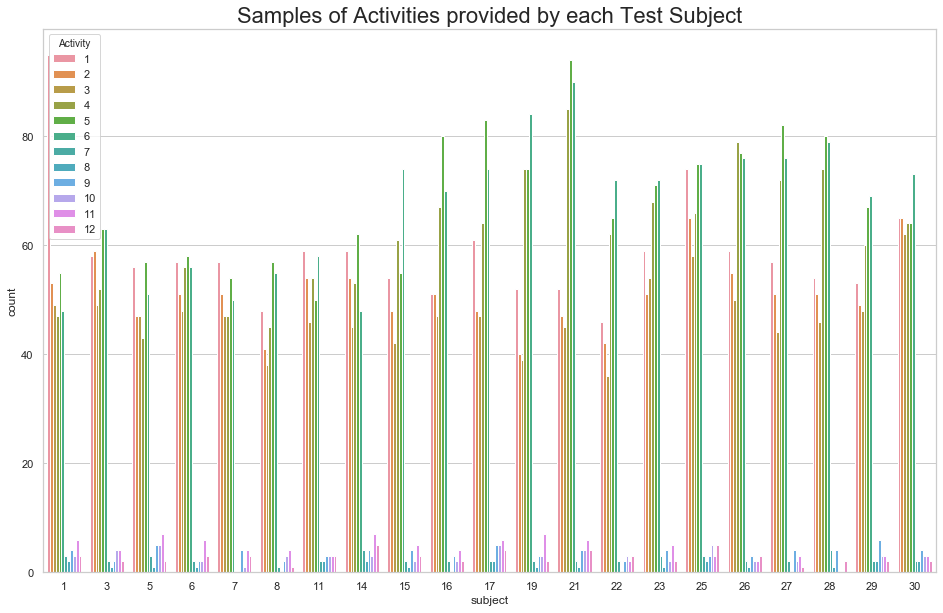

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(16,10))
plt.title('Samples of Activities provided by each Test Subject', fontsize=22)
sns.countplot(x='subject',hue='Activity', data = X_train2)
plt.show()

From the chart above of count vs subjects, we can see that Data is almost balanced from each of the subjects.

In [191]:
variables = ['fBodyAcc-Mean-1', 'fBodyAcc-Mean-2', 'fBodyAcc-Mean-3']

In [192]:
# get X_train and y_train from csv files and drop the "subject and Activity" columns
X_train2 = X_train2.drop(['subject', 'Activity'], axis=1)
X_train2

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.012236,-0.314848,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,0.202804,-0.603199,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,0.440079,-0.404427,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271
3,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,-0.798477,...,0.430891,-0.138373,-0.491604,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826
4,0.038758,-0.002289,-0.023863,-0.998241,-0.986774,-0.993115,-0.998216,-0.986479,-0.993825,-0.801982,...,0.137735,-0.366214,-0.702490,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7762,0.048048,-0.042445,-0.065884,-0.195448,-0.278326,-0.219954,-0.282233,-0.305861,-0.357803,0.267874,...,-0.008381,-0.596760,-0.879026,-0.190437,0.829718,0.206972,-0.425619,-0.792292,0.238580,0.056020
7763,0.037639,0.006430,-0.044345,-0.235372,-0.302680,-0.232843,-0.322483,-0.354464,-0.345592,0.181271,...,0.209452,-0.404418,-0.684496,0.064907,0.875679,-0.879033,0.400219,-0.772288,0.252653,0.056252
7764,0.037451,-0.002724,0.021009,-0.218281,-0.378082,-0.076950,-0.304446,-0.400661,-0.193071,0.113141,...,0.237003,0.000207,-0.317314,0.052806,-0.266724,0.864404,0.701169,-0.779566,0.249121,0.047071
7765,0.044011,-0.004536,-0.051242,-0.219202,-0.383350,-0.081035,-0.310419,-0.380233,-0.201007,0.166671,...,0.069366,0.037919,-0.356579,-0.101360,0.700740,0.936674,-0.589479,-0.785603,0.246409,0.031700


In [193]:
# get X_test and y_test from csv files and drop the "subject and Activity" columns
X_test2 = X_test2.drop(['subject', 'Activity'], axis=1)
X_test2

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.030914,-0.008927,0.040382,-0.938504,-0.944626,-0.759334,-0.952398,-0.950281,-0.802483,-0.757099,...,0.122830,-0.345684,-0.709087,0.006462,0.162920,-0.825886,0.271151,-0.720559,0.276779,-0.051074
1,0.042548,0.001079,-0.026236,-0.975516,-0.977502,-0.960146,-0.986694,-0.978983,-0.966820,-0.757099,...,-0.314688,-0.142804,-0.600867,-0.083495,0.017500,-0.434375,0.920593,-0.698684,0.281322,-0.076825
2,0.038297,-0.011660,-0.025643,-0.993922,-0.979215,-0.973030,-0.994298,-0.980535,-0.977508,-0.799005,...,0.114730,-0.209525,-0.645500,-0.034956,0.202302,0.064103,0.145068,-0.703355,0.280062,-0.072302
3,0.036205,-0.018148,-0.025240,-0.994845,-0.981534,-0.976175,-0.995169,-0.983020,-0.980785,-0.798401,...,0.164515,-0.359352,-0.738474,-0.017067,0.154438,0.340134,0.296407,-0.699545,0.284093,-0.070079
4,0.038034,-0.013437,-0.032899,-0.993955,-0.977493,-0.984290,-0.994006,-0.977354,-0.985899,-0.798401,...,-0.056085,-0.544467,-0.846150,-0.002223,-0.040046,0.736715,-0.118545,-0.692849,0.290701,-0.066849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,0.052279,-0.038687,-0.013494,-0.287933,-0.403601,-0.431550,-0.356012,-0.433826,-0.534817,0.244280,...,0.125445,-0.390349,-0.752788,-0.337422,0.346295,0.884904,-0.698885,-0.652416,0.274605,0.190104
3158,0.073745,-0.024673,-0.017836,-0.305455,-0.286487,-0.417996,-0.373468,-0.354849,-0.557925,0.244280,...,0.150787,-0.336001,-0.703532,-0.736701,-0.372889,-0.657421,0.322548,-0.655858,0.273556,0.187748
3159,0.068334,0.043822,-0.024135,-0.329706,-0.335273,-0.456965,-0.387944,-0.423504,-0.604403,0.079255,...,-0.004765,-0.139894,-0.476335,-0.181560,0.088574,0.696664,0.363139,-0.656034,0.274457,0.186527
3160,0.023016,0.032345,-0.011830,-0.323182,-0.465502,-0.426108,-0.392307,-0.520848,-0.569571,0.079255,...,0.013540,-0.224141,-0.623083,0.444558,-0.819188,0.929294,-0.008398,-0.660387,0.264759,0.192865


###  Visualization of Feature Distribution 
#### Stationary and Moving activities are completely different
With static activities, (sit, stand, lie) motion information will not be very useful.
In the dynamic activities (walking, walkingupstairs, walkingdownstairs) motion info will be significant. 

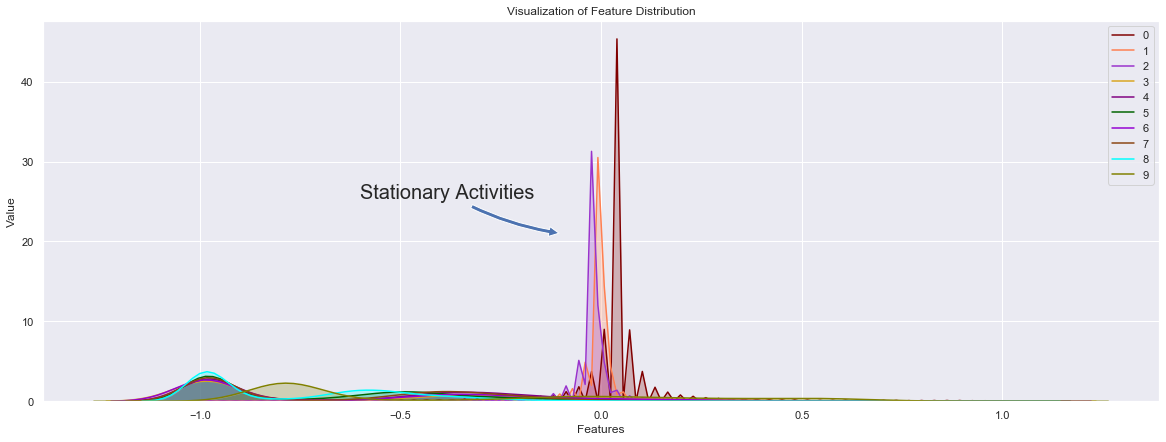

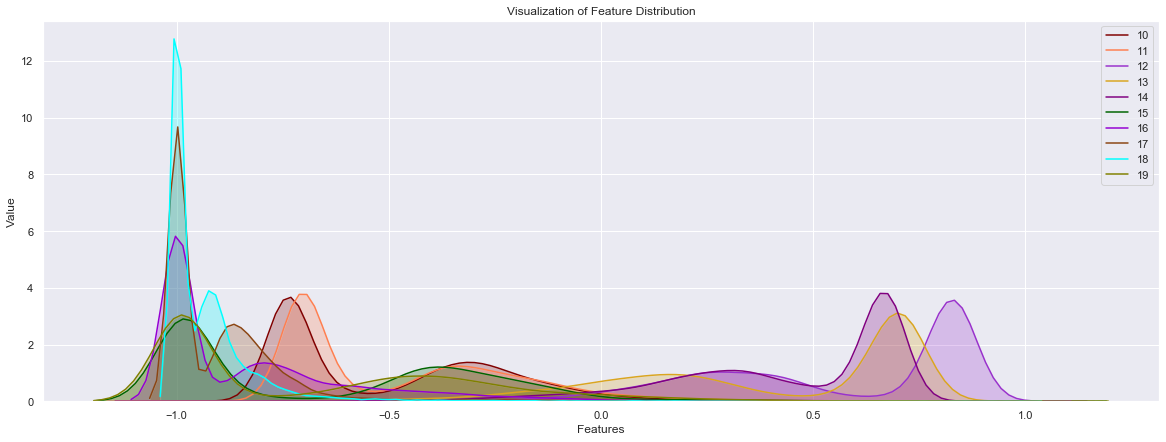

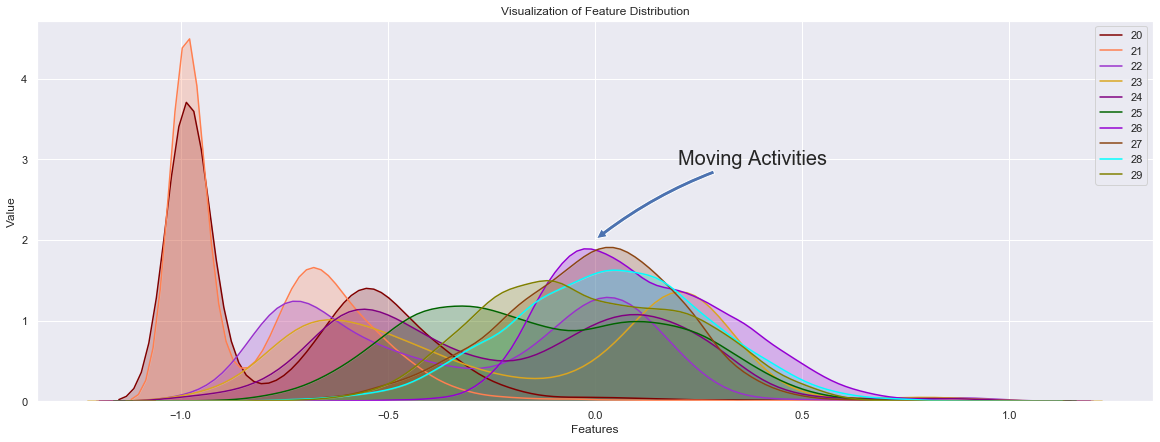

In [194]:
df = X_train2

sns.set(rc={'figure.figsize':(20,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in df.columns[0:10]:
    index = index + 1
    fig = sns.kdeplot(df[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Visualization of Feature Distribution")
plt.grid(True)
plt.annotate("Stationary Activities", xy=(-0.1,21), xytext=(-0.6, 26), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))

plt.show(fig)

index = -1
for i in df.columns[10:20]:
    index = index + 1
    fig = sns.kdeplot(df[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Visualization of Feature Distribution")
plt.grid(True)
plt.show(fig)

index = -1
for i in df.columns[20:30]:
    index = index + 1
    fig = sns.kdeplot(df[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Visualization of Feature Distribution")
plt.grid(True)
plt.annotate("Moving Activities", xy=(0,2), xytext=(0.2, 3), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))
plt.show(fig)

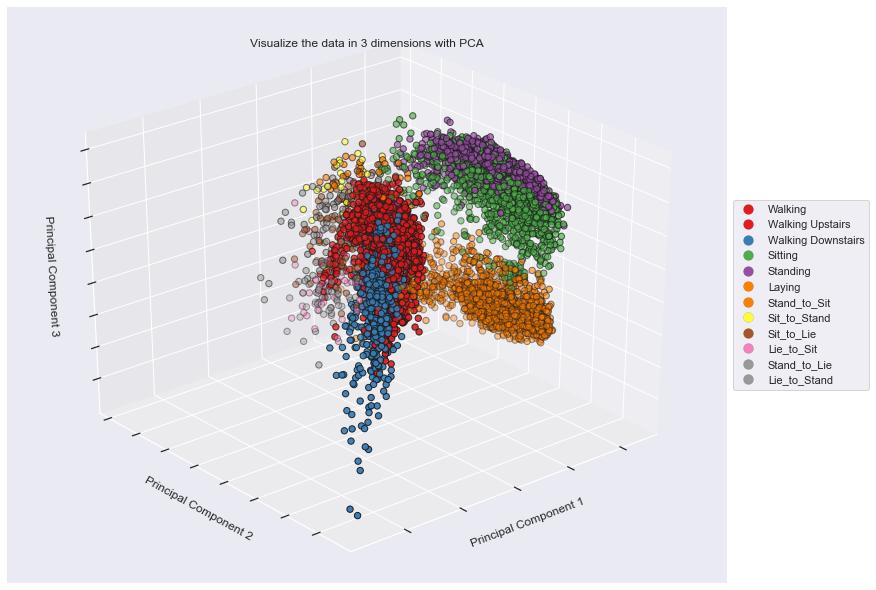

In [195]:
# A visual exploration of the data in 3 dimensions by principal components.
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_train2)
y = y_train2['Y']

labels = [('Walking', 1), ('Walking Upstairs', 2), ('Walking Downstairs', 3), 
          ('Sitting', 4), ('Standing', 5), ('Laying', 6),
          ('Stand_to_Sit', 7), ('Sit_to_Stand', 8), ('Sit_to_Lie', 9), 
          ('Lie_to_Sit', 10), ('Stand_to_Lie', 11),('Lie_to_Stand', 12) ]

fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig, elev=-150, azim=130)
sc= ax.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], c=y, cmap='Set1', edgecolor='k', s=40)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

# create the events marking the x data points
colors = [sc.cmap(sc.norm(i)) for i in [1,2,3,4,5,6,7,8,9,10,11,12]]
custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                mec='k', mfc=c, mew=.1, ms=20) for c in colors]
ax.legend(custom_lines, [l[0] for l in labels], 
          loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('Visualize the data in 3 dimensions with PCA')

plt.show()

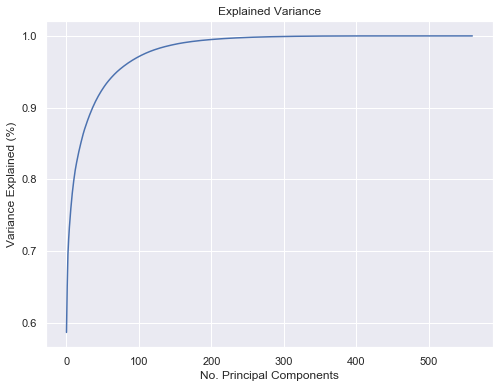

In [196]:
pca = PCA()
X_pca = pca.fit_transform(X_train2)

# function borrowed from course content
def screen_plot(pca):
    '''
    Creates a screen plot associated with the principal components and displays the cumulative variance explained
    
    INPUT: pca - the result of instantiating PCA in sklearn
            
    OUTPUT: None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(8, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)

    ax.plot(ind, cumvals)

    ax.set_xlabel("No. Principal Components")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance')
    
screen_plot(pca)

####  From this Explained Variance curve we can see that ~100 principal components capture more than (.95) 95% of the variance explained in the X train data. And ~200 principal components capture nearly 100%.

###  Below is a function for plotting the confusion matrix of the model.
The code is taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

In [197]:
def tuple_Labels():
    labels_tuple = [('Walking', 1), ('Walking Upstairs', 2), ('Walking Downstairs', 3), 
          ('Sitting', 4), ('Standing', 5), ('Laying', 6),
          ('Stand_to_Sit', 7), ('Sit_to_Stand', 8), ('Sit_to_Lie', 9), 
          ('Lie_to_Sit', 10), ('Stand_to_Lie', 11),('Lie_to_Stand', 12) ]
    return(labels_tuple)
labels_tuple = tuple_Labels

In [198]:
def listLabels():
    a = np.array(activity_labels2.Activity.unique())
    Labels = a.tolist()
    return(Labels)
Labels = listLabels()
print(Labels)

['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND']


In [199]:
# Confusion Matrix Display Function
# Display normalized_confusion_matrix , Provide classification_report
# The confusion matrix is plotted to get better insight of model performance
# The model performance is evident from the diagonal concentration of the values
# prints classification report of Precision-Recall, f1-score accuracy scores
# The classification_report function builds a text report showing the main classification metrics.
#  precision is the ability of the classifier not to label as positive a sample that is negative, 
#  and recall is the ability of the classifier to find all the positive sample

def confusion_matrix_display(cmTitle, y_test, y_pred):
    # confusion matrix usage to evaluate the quality of the output of a classifier on the data set.
    # https://github.com/todddangerfarr/mlnd-p5-capstone-wearables-activity-tracking/blob/master/human-activities-and-postural-transitions.ipyn
    cm = confusion_matrix(y_test, y_pred)
    # get the activities numpy array and convert to a list of Labels
    a = np.array(activity_labels2.Activity.unique())
    Labels = a.tolist()

    colormap = plt.cm.Blues
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes()
    sns.set(style='whitegrid', font_scale=1.5)
    sns.heatmap(cm, 
                #fmt='.0f',
                fmt ='g',
                annot=True, 
                annot_kws={"size": 10},
                cmap=colormap,
                square=True,
                linecolor='white',
                xticklabels =Labels,
                yticklabels =Labels,
                ax = ax)

    ax.set_title(cmTitle + ' ' + 'Testing Confusion Matrix ')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")

    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    normalized_confusion_matrix = np.array(cm, dtype=np.float32)/np.sum(cm)*100
    print("")
    print("Normalized Confusion matrix (normalized to % of total test data):")
    print(normalized_confusion_matrix)

    # print classification report of Precision-Recall, f1-score accuracy scores
    # The classification_report function builds a text report showing the main classification metrics.
    #  precision is the ability of the classifier not to label as positive a sample that is negative, 
    # and recall is the ability of the classifier to find all the positive sample
    from sklearn.metrics import classification_report, accuracy_score
    print("classification_report")
    print(classification_report(y_test, y_pred, target_names=Labels))
    crvalue = classification_report(y_test, y_pred, target_names=Labels)
    return(crvalue)

## Classification Using Logistic Regression with Scikit-learn

The objective is to build a classifier that can classify the different activity types, even when extended to new data (i.e.: new participants). Accuracy will therefore be used as the evaluation metric.

We will first build our benchmark model using LogisticRegression from Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers.
The version of Logistic Regression in Scikit-learn, supports regularization. Regularization is a technique used to solve the overfitting problem in machine learning models. C parameter indicates inverse of regularization strength which must be a positive float. Smaller values specify stronger regularization. Now lets fit our model with train set:

ref: https://github.com/anandprabhakar0507/Python-logistic-regression/blob/master/ML0101EN-Clas-Logistic-Reg-churn-py-v1.ipynb
More information on the math behind LogisticRegression can be found at https://medium.com/@udaybhaskarpaila/math-behind-logistic-regression-3d7d53ec3091

In [200]:
# Logistic Regression

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Xsc_train = sc.fit_transform(X_train2)
Xsc_test = sc.fit_transform(X_test2)
    
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression

# Best results obtained with 'lbfgs' solver
LRclassifier = LogisticRegression(random_state = 0, solver= 'lbfgs')

start = time.time()
LRclassifier.fit(X_train2, y_train2)
end = time.time()
total_training_time = end - start
print ("Done!\nTraining time (secs): {:.3f}".format(total_training_time))
LR_total_training_time = total_training_time

# Predicting the Training set results
LR_pred_train = LRclassifier.predict(X_train2)
# Predicting the Test set results
y_pred = LRclassifier.predict(X_test2)
LR_pred_test = y_pred
print('Accuracy score TRAIN: {:.3f}%'.format(accuracy_score(y_train2, LR_pred_train)*100))
print('Accuracy score TEST: {:.3f}%'.format(accuracy_score(y_test2, y_pred)*100))

Done!
Training time (secs): 9.953
Accuracy score TRAIN: 98.983%
Accuracy score TEST: 94.655%


### Confusion matrix of our Model and Classification Report

The next table shows the confusion matrix for our problem. In the confusion matrix, the rows represent the real classes 
and the columns the predicted classes for the testing data.

classification_report for Logistic Regression 


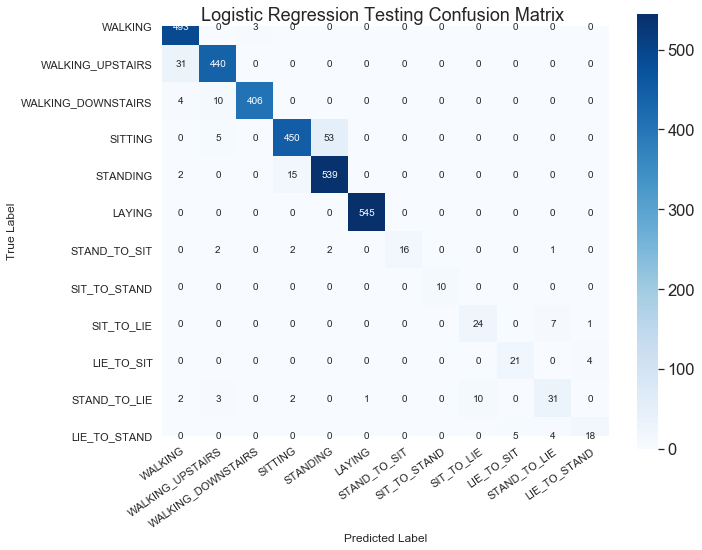


Normalized Confusion matrix (normalized to % of total test data):
[[15.591398    0.          0.09487666  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.9803922  13.915244    0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.12650222  0.31625554 12.839974    0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.15812777  0.         14.231499    1.6761544   0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.06325111  0.          0.          0.4743833  17.046173    0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         17.235928
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.06325111  0.          0.06325111  0.06325111  0.
   0.50600886  

In [201]:
# PLotting the confusion matrix of our model
print("classification_report for Logistic Regression ")
    
LR_precision_recall_fscore_support  = confusion_matrix_display('Logistic Regression', y_test2, y_pred)

In [202]:
d = { "Index":np.arange(3162) , "Activity":y_pred }
final = pd.DataFrame(d)
final.to_csv('./data/HAPT Data Set/human_activity_predictions.csv' , index = False)
HARpredictions = pd.read_csv('./data/HAPT Data Set/human_activity_predictions.csv')
print(HARpredictions)

      Index  Activity
0         0         5
1         1         5
2         2         5
3         3         5
4         4         5
...     ...       ...
3157   3157         2
3158   3158         2
3159   3159         2
3160   3160         2
3161   3161         2

[3162 rows x 2 columns]


In [203]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
#The sklearn.metrics module implements several loss, score, and utility functions to measure regression performance. 
#Some of those have been enhanced to handle the multioutput case: mean_squared_error, mean_absolute_error,explained_variance_score and r2_score.

In [204]:
# zero_one_loss
from sklearn.metrics import zero_one_loss
# The zero_one_loss function computes the sum or the average of the 0-1 classification loss (L0−1) over nsamples
print('zero one loss')
zero_one_loss(y_test2, y_pred)

zero one loss


0.05344718532574322

In [205]:
# max_error
from sklearn.metrics import max_error
max_error(y_test2, y_pred)

10

In [206]:
# The r2_score function computes the coefficient of determination, usually denoted as R².
# It represents the proportion of variance (of y) that has been explained by the independent variables in the model. 
# It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted
# by the model, through the proportion of explained variance.
# As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. 
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.
from sklearn.metrics import r2_score
LRr2 = r2_score(y_test2, y_pred)
print("r2 score: ", LRr2)

r2 score:  0.9385354878710664


In [207]:
# matthews_corrcoef
# “The Matthews correlation coefficient is used in machine learning as a measure of the quality of 
# binary (two-class) classifications. It takes into account true and false positives and negatives 
# and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
# https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
from sklearn.metrics import matthews_corrcoef
print('matthews_corrcoef')
matthews_corrcoef(y_test2, y_pred)

matthews_corrcoef


0.9372016938861301

## Classification Using AdaBoostClassifier with Scikit-learn

In [208]:
# https://towardsdatascience.com/boosting-algorithm-adaboost-b6737a9ee60c
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Xsc_train = sc.fit_transform(X_train2)
Xsc_test = sc.fit_transform(X_test2)

# declare an errorlist
error_list = list()
# Iterate through all of the possibilities for number of estimators
tree_list = [15, 50, 100, 200, 400, 500]

# Setting max_features=4 in the decision tree classifier used as the base classifier 
# for AdaBoost will increase the convergence rate
base = DecisionTreeClassifier(max_features=5, max_depth=6)
# base = RandomForestClassifier(max_features=4)

print(...)
for n_trees in tree_list:
     #create model
    ABclassifier = AdaBoostClassifier(base_estimator=base, n_estimators=n_trees, 
                             learning_rate=0.01, random_state=42, algorithm="SAMME")
    start = time.time()
    ABclassifier.fit(X_train2, y_train2)
    end = time.time()
    total_training_time = end - start
    ABc_total_training_time = total_training_time
    # Get the error
    error = 1. - accuracy_score(y_test2, y_pred)
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

err_abc = pd.concat(error_list, axis=1).T.set_index('n_trees')  
print ("Done!\nTraining time (secs): {:.3f}".format(total_training_time))

# Predicting the Training set results
ABCTrain_pred = ABclassifier.predict(X_train2)
# Predicting the Test set results
y_pred = ABclassifier.predict(X_test2)
ABC_pred_test = y_pred
print('Accuracy score TRAIN: {:.3f}%'.format(accuracy_score(y_train2, ABCTrain_pred)*100))
print('Accuracy score TEST: {:.3f}%'.format(accuracy_score(y_test2, y_pred)*100))

Ellipsis
Done!
Training time (secs): 33.703
Accuracy score TRAIN: 99.717%
Accuracy score TEST: 93.137%


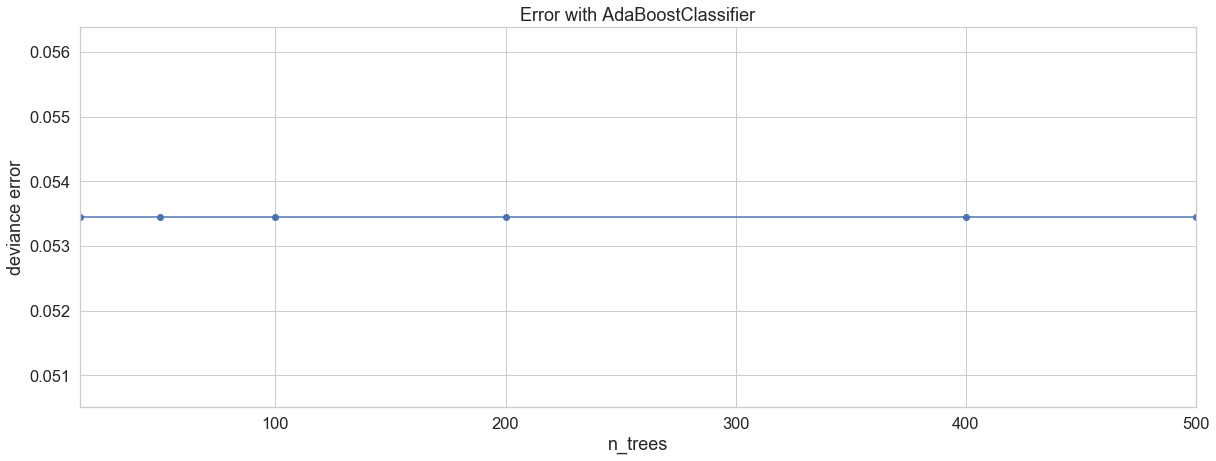

In [209]:
# Plot the result
ax = err_abc.plot(legend=False, marker='o')
ax.set_ylabel('deviance error')
ax.set_title('Error with AdaBoostClassifier')
plt.show()

### Confusion matrix of our Model and Classification Report

classification_report for AdaBoostClassifier 


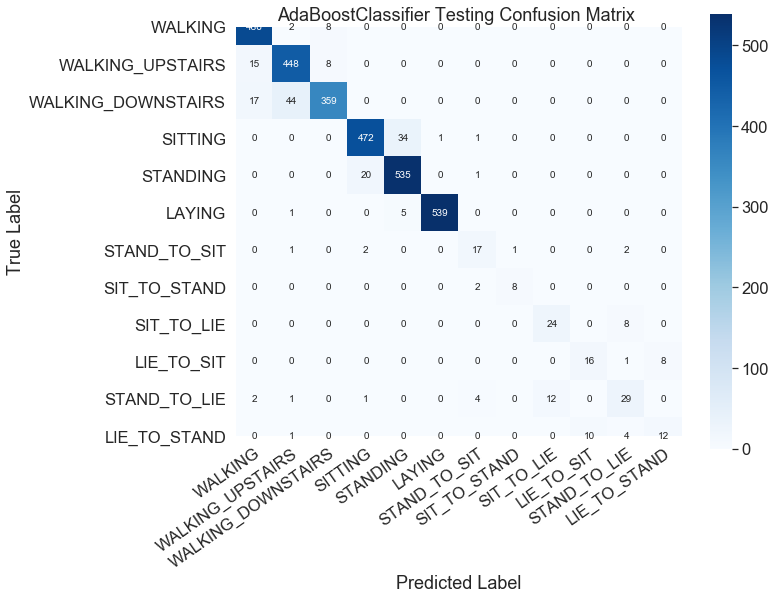


Normalized Confusion matrix (normalized to % of total test data):
[[15.370019    0.06325111  0.25300443  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.4743833  14.168247    0.25300443  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.53763443  1.3915243  11.353574    0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         14.92726     1.0752689   0.03162555
   0.03162555  0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.6325111  16.91967     0.
   0.03162555  0.          0.          0.          0.          0.        ]
 [ 0.          0.03162555  0.          0.          0.15812777 17.046173
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.03162555  0.          0.06325111  0.          0.
   0.53

In [210]:
# PLotting the confusion matrix of our model
# Classification Report
print("classification_report for AdaBoostClassifier ")
AB_precision_recall_fscore_support  = confusion_matrix_display('AdaBoostClassifier', y_test2, y_pred)

In [211]:
# The r2_score function computes the coefficient of determination, usually denoted as R².
# It represents the proportion of variance (of y) that has been explained by the independent variables in the model. 
# It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted
# by the model, through the proportion of explained variance.
# As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. 
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.
from sklearn.metrics import r2_score
ABC_r2 = r2_score(y_test2, y_pred)
print("r2 score: ", ABC_r2)

r2 score:  0.9368777313198712


In [212]:
# “The Matthews correlation coefficient is used in machine learning as a measure of the quality of 
# binary (two-class) classifications. It takes into account true and false positives and negatives 
# and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
# https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
from sklearn.metrics import matthews_corrcoef
ABC_mc = matthews_corrcoef(y_test2, y_pred)
print('matthews_corrcoef: ', ABC_mc)

matthews_corrcoef:  0.9192826692348254


## Classification Using GradientBoostingClassifier with Scikit-learn

Boosting refers to a group of algorithms that utilize weighted averages to make weak learners into stronger learners. Unlike bagging that had each model run independently and then aggregate the outputs at the end without preference to any model. Boosting is all about “teamwork”. Each model that runs, dictates what features the next model will focus on. Result is weighted sum of all classifiers. Successive classifiers are weighted by learning rate (λ). Using a learning rate < 1.0 helps prevent overfitting (regularization).

In [213]:
# GradientBoostingClassifier
# Iterate through all of the possibilities for number of estimators
# declare an errorlist
error_list = list()
tree_list = [15, 50, 100, 200, 400, 500]

start = time.time()
print(start)
for n_trees in tree_list:
        # lr of .1 performed better than eta/various try of rates.
        GBclassifier = GradientBoostingClassifier(n_estimators=n_trees,
                                             random_state=0, max_features=5, learning_rate=0.1)

        GBclassifier.fit(X_train2, y_train2)
        end = time.time()
        total_training_time = end - start
        GBc_total_training_time = total_training_time
        # Get the error
        error = 1. - accuracy_score(y_test2, y_pred)
        error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

err_gbc = pd.concat(error_list, axis=1).T.set_index('n_trees')       
print ("Done!\nTraining time (secs): {:.3f}".format(total_training_time))

# Predicting the Training set results
GBCy_pred = GBclassifier.predict(X_train2)
# Predicting the Test set results
y_pred = GBclassifier.predict(X_test2)
GBC_pred_test = y_pred

print('Accuracy score TRAIN: {:.3f}%'.format(accuracy_score(y_train2, GBCy_pred)*100))
print('Accuracy score TEST: {:.3f}%'.format(accuracy_score(y_test2, y_pred)*100))

1576897044.4626086
Done!
Training time (secs): 64.464
Accuracy score TRAIN: 100.000%
Accuracy score TEST: 93.201%


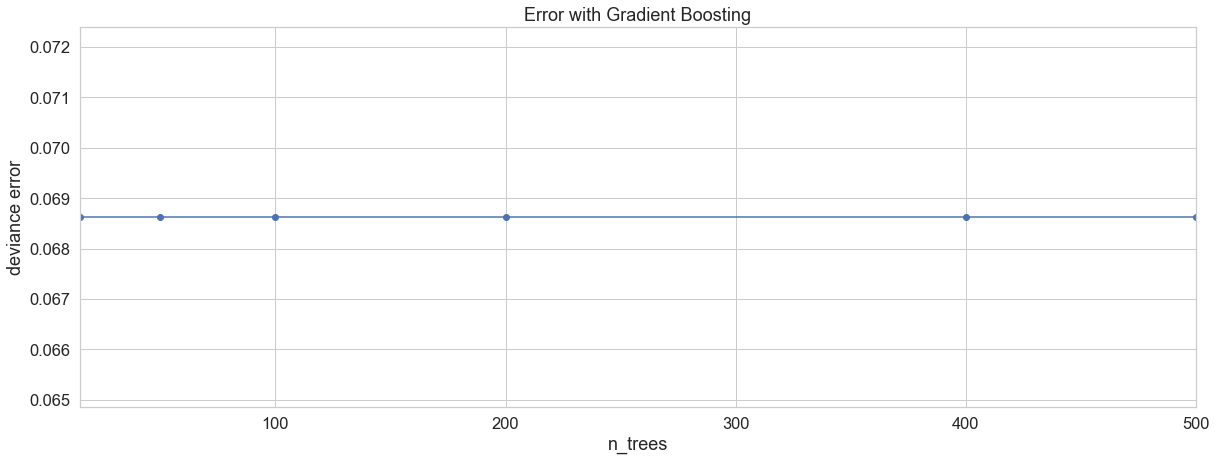

In [214]:
# Plot the result
ax = err_gbc.plot(legend=False, marker='o')
ax.set_ylabel('deviance error')
ax.set_title('Error with Gradient Boosting')
plt.show()

classification_report for GradientBoostingClassifier 
 


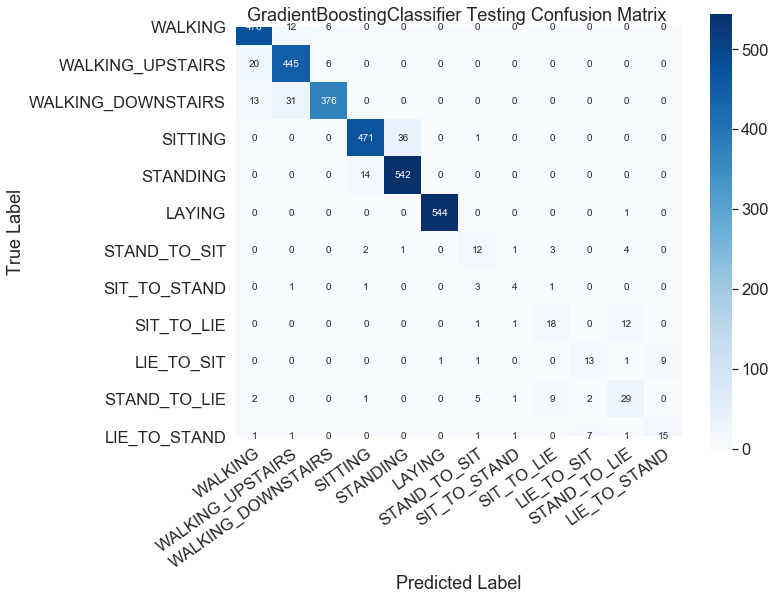


Normalized Confusion matrix (normalized to % of total test data):
[[15.117015    0.37950665  0.18975332  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.6325111  14.073372    0.18975332  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.41113222  0.9803922  11.891208    0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         14.895636    1.13852     0.
   0.03162555  0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.44275773 17.14105     0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         17.204302
   0.          0.          0.          0.          0.03162555  0.        ]
 [ 0.          0.          0.          0.06325111  0.03162555  0.
   0.37950665  

In [215]:
# PLotting the confusion matrix of our model
# Classification Report
print("classification_report for GradientBoostingClassifier ")
print(" ")
GB_precision_recall_fscore_support  = confusion_matrix_display('GradientBoostingClassifier', y_test2, y_pred)

In [216]:
# The r2_score function computes the coefficient of determination, usually denoted as R².
# It represents the proportion of variance (of y) that has been explained by the independent variables in the model. 
# It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted
# by the model, through the proportion of explained variance.
# As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. 
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.
from sklearn.metrics import r2_score
GBCr2 = r2_score(y_test2, y_pred)
print("r2 score: ", GBCr2)

r2 score:  0.9256559946656261


In [217]:
# “The Matthews correlation coefficient is used in machine learning as a measure of the quality of 
# binary (two-class) classifications. It takes into account true and false positives and negatives 
# and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
# https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
from sklearn.metrics import matthews_corrcoef
GBC_mc = matthews_corrcoef(y_test2, y_pred)
print('matthews_corrcoef: ', GBC_mc)

matthews_corrcoef:  0.9199459987598686


## Classification Using KNeighborsClassifier  with Scikit-learn  

In [218]:
# ref: https://github.com/hardik04021996/Human-Activity-Recognition-using-machine-learning/blob/master/kNN%2Bfor%2BHuman%2BActivity%2BRecognition.ipynb
# KNeighborsClassifier (KNN) to the data 

#Finding the optimal model by varying the no. of neighbors
scores = []
n_neighbors_max = 11   # score started going down after 11
start = time.time()
print(start)
for i in range(1, n_neighbors_max):
    print ("calculating optimal model....n_neighbors:" , i) 
    knn = KNeighborsClassifier(n_neighbors = i, n_jobs = -1)
    knn.fit(X_train2, y_train2.values.ravel())                          
    end = time.time()
    total_training_time = end - start
    kn_total_training_time = total_training_time
    # Predicting the Training set results
    kn_train_pred = knn.predict(X_train2)
    # Predicting the Test set results
    y_pred = knn.predict(X_test2)
    kn_pred_test = y_pred
    scores.append(accuracy_score(y_test2, y_pred))   
print ("Done!\nTraining time (secs): {:.3f}".format(total_training_time))

print('Accuracy score TRAIN: {:.3f}%'.format(accuracy_score(y_train2, kn_train_pred)*100))
print('Accuracy score TEST: {:.3f}%'.format(accuracy_score(y_test2, y_pred)*100))

1576897111.5342548
calculating optimal model....n_neighbors: 1
calculating optimal model....n_neighbors: 2
calculating optimal model....n_neighbors: 3
calculating optimal model....n_neighbors: 4
calculating optimal model....n_neighbors: 5
calculating optimal model....n_neighbors: 6
calculating optimal model....n_neighbors: 7
calculating optimal model....n_neighbors: 8
calculating optimal model....n_neighbors: 9
calculating optimal model....n_neighbors: 10
Done!
Training time (secs): 213.849
Accuracy score TRAIN: 96.511%
Accuracy score TEST: 88.836%


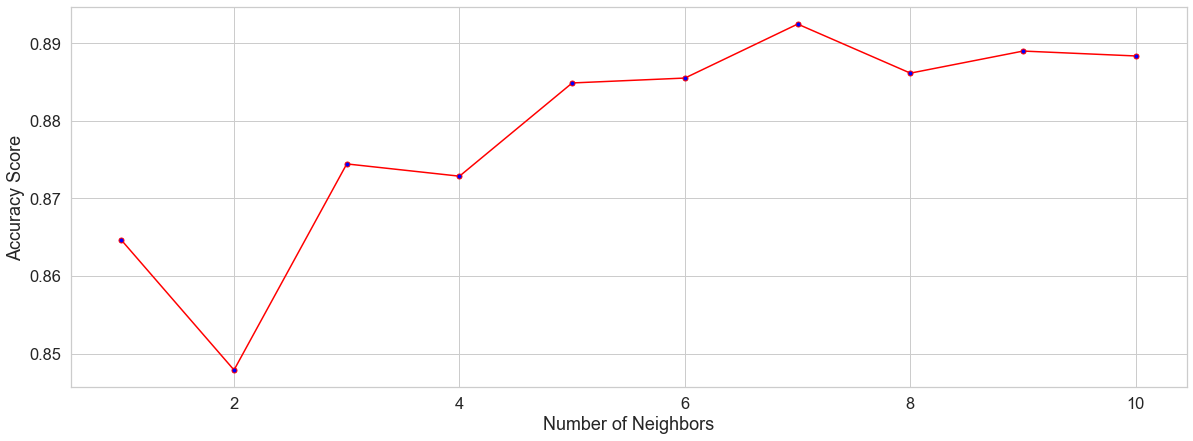

In [219]:
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy Score')
xticks = range(1,n_neighbors_max)
plt.plot(xticks, scores, color='red', linestyle='solid', marker='o',markerfacecolor='blue', markersize=5)

In [220]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

In [221]:
plt.show()

In [222]:
scores = np.array(scores)

In [223]:
#Final result after training the model
print('Optimal No. Of Neighbors: ', scores.argmax()+1)
print('Accuracy Score: '+ str(scores.max()*100)+ ' %')

Optimal No. Of Neighbors:  7
Accuracy Score: 89.24731182795699 %


classification_report for KNeighborsClassifier 


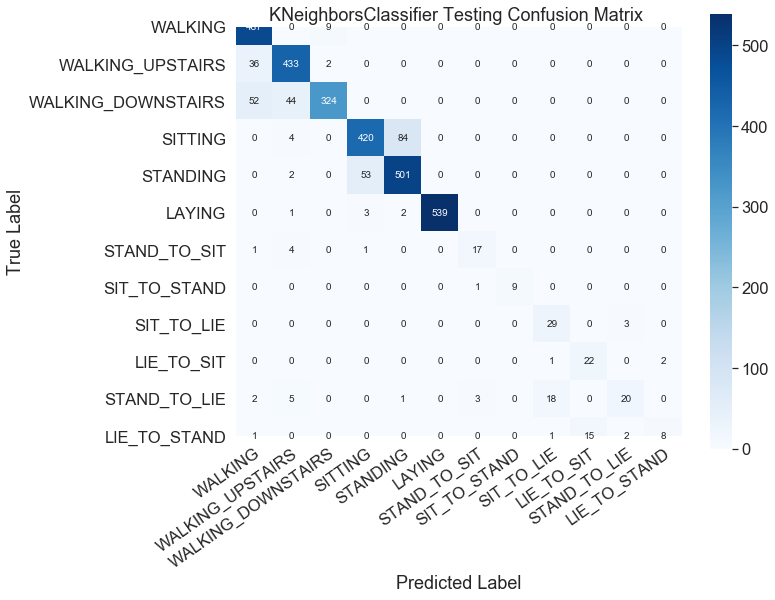


Normalized Confusion matrix (normalized to % of total test data):
[[15.401645    0.          0.28463     0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 1.13852    13.693865    0.06325111  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 1.6445289   1.3915243  10.246679    0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.12650222  0.         13.282733    2.6565464   0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.06325111  0.          1.6761544  15.844401    0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.03162555  0.          0.09487666  0.06325111 17.046173
   0.          0.          0.          0.          0.          0.        ]
 [ 0.03162555  0.12650222  0.          0.03162555  0.          0.
   0.53763443  

In [224]:
# PLotting the confusion matrix of our model
# Classification Report
print("classification_report for KNeighborsClassifier ")
KN_precision_recall_fscore_support  = confusion_matrix_display('KNeighborsClassifier', y_test2, y_pred)

In [225]:
# The r2_score function computes the coefficient of determination, usually denoted as R².
# It represents the proportion of variance (of y) that has been explained by the independent variables in the model. 
# It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted
# by the model, through the proportion of explained variance.
# As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. 
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.
from sklearn.metrics import r2_score
kn_r2 = r2_score(y_test2, y_pred)
print("r2 score: ", kn_r2)

r2 score:  0.894987498468513


In [226]:
# “The Matthews correlation coefficient is used in machine learning as a measure of the quality of 
# binary (two-class) classifications. It takes into account true and false positives and negatives 
# and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
# https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
from sklearn.metrics import matthews_corrcoef
kn_mc = matthews_corrcoef(y_test2, y_pred)
print('matthews_corrcoef: ', kn_mc)

matthews_corrcoef:  0.8691507772801703


## Classification Using RandomForestClassifier with Scikit-learn 

In [227]:
# ref: https://github.com/bcheung888/udacity-capstone/blob/master/Human%20Activity%20Recognition.ipynb

from sklearn.ensemble import RandomForestClassifier
# fit random forest to the data

# declare an errorlist
error_list = list()
# set n_estimators to 100. 10 is a bit low
tree_list = [15, 50, 100, 200, 400, 500]
start = time.time()
print(start)
for n_trees in tree_list:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    rf.fit(X_train2, y_train2.values.ravel())
    end = time.time()
    total_training_time = end - start
    rf_total_training_time = total_training_time
    # Get the error
    error = 1. - accuracy_score(y_test2, y_pred)
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

err_rfc = pd.concat(error_list, axis=1).T.set_index('n_trees')       

print ("Done!\nTraining time (secs): {:.3f}".format(total_training_time))

# Predicting the Training set results
rfy_pred = rf.predict(X_train2)
# Predicting the Test set results
y_pred = rf.predict(X_test2)
rf_pred_test = y_pred
print('Accuracy score TRAIN: {:.3f}'.format(accuracy_score(y_train2, rfy_pred)*100))
print('Accuracy score TEST: {:.3f}'.format(accuracy_score(y_test2, y_pred)*100))

1576897352.8712475
Done!
Training time (secs): 165.407
Accuracy score TRAIN: 100.000
Accuracy score TEST: 91.145


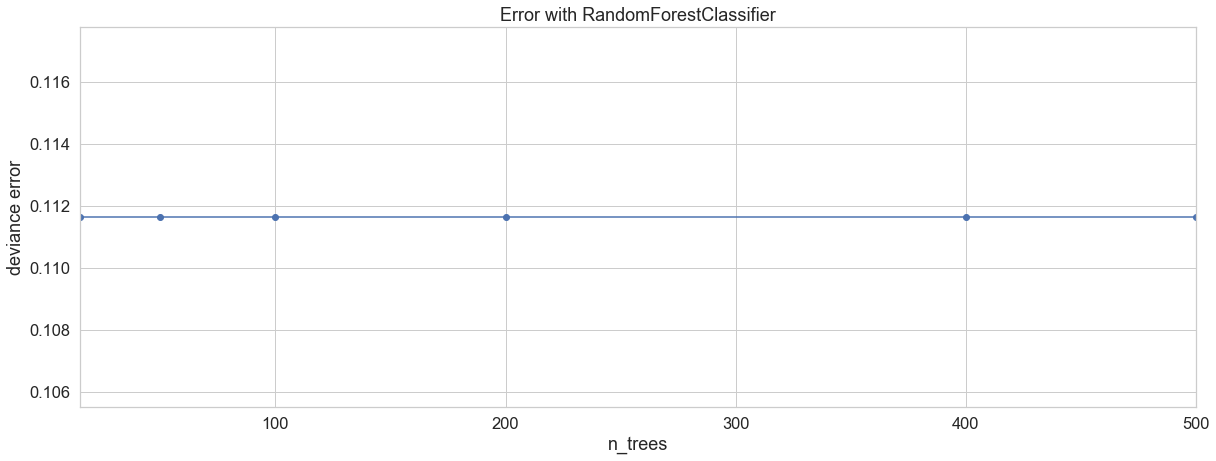

In [228]:
# Plot the result
ax = err_rfc.plot(legend=False, marker='o')
ax.set_ylabel('deviance error')
ax.set_title('Error with RandomForestClassifier')
plt.show()

classification_report for RandomForestClassifier


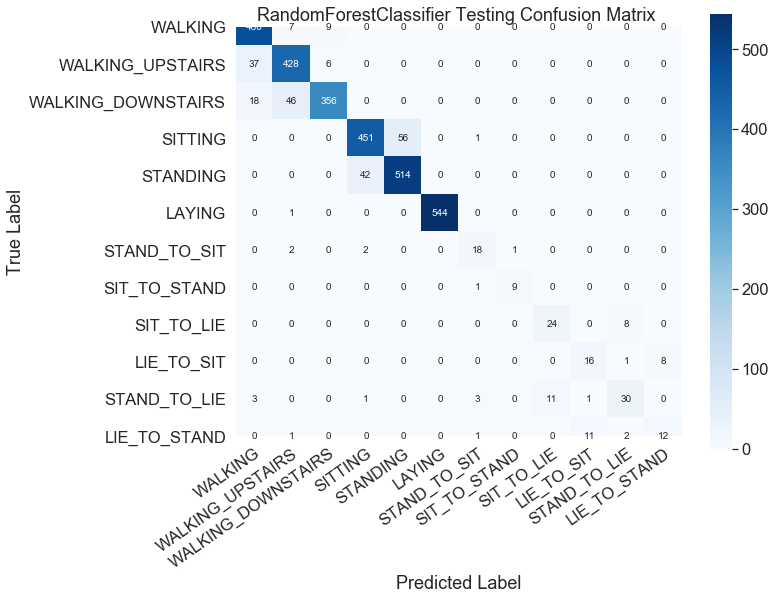


Normalized Confusion matrix (normalized to % of total test data):
[[15.180265    0.22137886  0.28463     0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 1.1701454  13.535736    0.18975332  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.56926     1.4547755  11.258697    0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         14.263124    1.7710309   0.
   0.03162555  0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.3282732  16.255535    0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.03162555  0.          0.          0.         17.204302
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.06325111  0.          0.06325111  0.          0.
   0.56926     

In [229]:
# PLotting the confusion matrix of our model
# Classification Report
print("classification_report for RandomForestClassifier")
RF_precision_recall_fscore_support  = confusion_matrix_display('RandomForestClassifier', y_test2, y_pred)

In [230]:
# The r2_score function computes the coefficient of determination, usually denoted as R².
# It represents the proportion of variance (of y) that has been explained by the independent variables in the model. 
# It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted
# by the model, through the proportion of explained variance.
# As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. 
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.
from sklearn.metrics import r2_score
rf_r2 = r2_score(y_test2, y_pred)
print("r2 score: ", rf_r2)

r2 score:  0.9314581425948096


In [231]:
# “The Matthews correlation coefficient is used in machine learning as a measure of the quality of 
# binary (two-class) classifications. It takes into account true and false positives and negatives 
# and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
# https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
from sklearn.metrics import matthews_corrcoef
rf_mc = matthews_corrcoef(y_test2, y_pred)
print('matthews_corrcoef: ', rf_mc)

matthews_corrcoef:  0.8958103857750876


## Classification Using LinearSVC  with Scikit-learn 

In [232]:
from sklearn.svm import LinearSVC, SVC
# Fit a linear SVM to the data
start = time.time()
print(start)
svc = LinearSVC(random_state=42)
svc.fit(X_train2, y_train2.values.ravel())

end = time.time()
total_training_time = end - start
print ("Done!\nTraining time (secs): {:.3f}".format(total_training_time))
SVC_total_training_time = total_training_time
# Predicting the Training set results
SVC_train_pred = svc.predict(X_train2)
# Predicting the Test set results
y_pred = svc.predict(X_test2)
SVC_pred_test = y_pred

print('Accuracy score TRAIN:: {:.3f}'.format(accuracy_score(y_train2, SVC_train_pred)*100))
print('Accuracy score TEST: {:.3f}'.format(accuracy_score(y_test2, y_pred)*100))

1576897521.2237933
Done!
Training time (secs): 7.516
Accuracy score TRAIN:: 99.472
Accuracy score TEST: 94.624


classification_report for LinearSVC


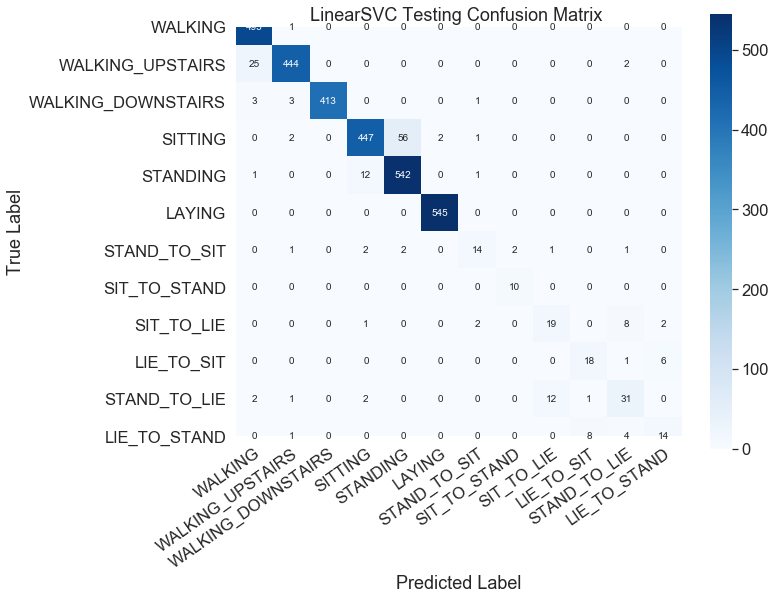


Normalized Confusion matrix (normalized to % of total test data):
[[15.654649    0.03162555  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.79063886 14.041746    0.          0.          0.          0.
   0.          0.          0.          0.          0.06325111  0.        ]
 [ 0.09487666  0.09487666 13.061354    0.          0.          0.
   0.03162555  0.          0.          0.          0.          0.        ]
 [ 0.          0.06325111  0.         14.136622    1.7710309   0.06325111
   0.03162555  0.          0.          0.          0.          0.        ]
 [ 0.03162555  0.          0.          0.37950665 17.14105     0.
   0.03162555  0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         17.235928
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.03162555  0.          0.06325111  0.06325111  0.
   0.44

In [233]:
# PLotting the confusion matrix of our model
# Classification Report
print("classification_report for LinearSVC")
SVC_precision_recall_fscore_support  = confusion_matrix_display('LinearSVC', y_test2, y_pred)

In [234]:
# The r2_score function computes the coefficient of determination, usually denoted as R².
# It represents the proportion of variance (of y) that has been explained by the independent variables in the model. 
# It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted
# by the model, through the proportion of explained variance.
# As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. 
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.
from sklearn.metrics import r2_score
SVC_r2 = r2_score(y_test2, y_pred)
print("r2 score: ", SVC_r2)

r2 score:  0.9313306228601023


In [235]:
# “The Matthews correlation coefficient is used in machine learning as a measure of the quality of 
# binSVC_r2ary (two-class) classifications. It takes into account true and false positives and negatives 
# and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
# https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
from sklearn.metrics import matthews_corrcoef
SVC_mc = matthews_corrcoef(y_test2, y_pred)
print('matthews_corrcoef: ', SVC_mc)

matthews_corrcoef:  0.9368834453110108


In [236]:
clf = SVC(random_state=42)

# try different kernels via gridsearch
parameters = {'kernel': ['poly', 'rbf', 'sigmoid']}
grid_obj =  GridSearchCV(clf, parameters, cv=3)

start = time.time()
print(start)
grid_fit = grid_obj.fit(X_train2, y_train2.values.ravel())
best_clf = grid_fit.best_estimator_

end = time.time()
total_training_time = end - start
print ("Done!\nTraining time (secs): {:.3f}".format(total_training_time))
SVC_grid_search_total_training_time = total_training_time
# Predicting the Training set results
train_pred = best_clf.predict(X_train2)
# Predicting the Test set results
best_pred = best_clf.predict(X_test2)
SVC_grid_search_test = best_pred
print(best_clf)
print('Accuracy score TRAIN: {:.3f}'.format(accuracy_score(y_train2, train_pred)*100))
print('Accuracy score TEST: {:.3f}'.format(accuracy_score(y_test2, best_pred)*100))

1576897530.2932868
Done!
Training time (secs): 163.262
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)
Accuracy score TRAIN: 93.975
Accuracy score TEST: 91.809


classification_report for LinearSVC with GridSearch


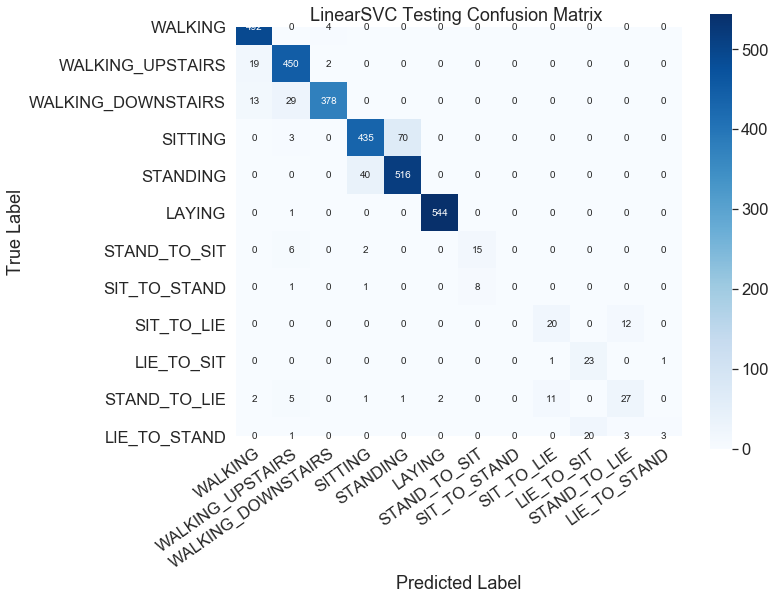


Normalized Confusion matrix (normalized to % of total test data):
[[15.559772    0.          0.12650222  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.6008855  14.231499    0.06325111  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.41113222  0.917141   11.954459    0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.09487666  0.         13.757115    2.2137887   0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.2650222  16.318787    0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.03162555  0.          0.          0.         17.204302
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.18975332  0.          0.06325111  0.          0.
   0.4743833   

'                    precision    recall  f1-score   support\n\n           WALKING       0.94      0.99      0.96       496\n  WALKING_UPSTAIRS       0.91      0.96      0.93       471\nWALKING_DOWNSTAIRS       0.98      0.90      0.94       420\n           SITTING       0.91      0.86      0.88       508\n          STANDING       0.88      0.93      0.90       556\n            LAYING       1.00      1.00      1.00       545\n      STAND_TO_SIT       0.65      0.65      0.65        23\n      SIT_TO_STAND       0.00      0.00      0.00        10\n        SIT_TO_LIE       0.62      0.62      0.62        32\n        LIE_TO_SIT       0.53      0.92      0.68        25\n      STAND_TO_LIE       0.64      0.55      0.59        49\n      LIE_TO_STAND       0.75      0.11      0.19        27\n\n          accuracy                           0.92      3162\n         macro avg       0.73      0.71      0.70      3162\n      weighted avg       0.92      0.92      0.91      3162\n'

In [237]:
# PLotting the confusion matrix of our model
# Classification Report
print("classification_report for LinearSVC with GridSearch")
confusion_matrix_display('LinearSVC', y_test2, best_pred)

In [238]:
# The r2_score function computes the coefficient of determination, usually denoted as R².
# It represents the proportion of variance (of y) that has been explained by the independent variables in the model. 
# It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted
# by the model, through the proportion of explained variance.
# As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. 
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.
from sklearn.metrics import r2_score
SVC_gs_r2 = r2_score(y_test2, best_pred)
print("r2 score: ", SVC_gs_r2)

r2 score:  0.9041051595000872


Intuitively, model performance depends on how similarly a new (test) participant performs the activities relative 
to the participants the model was trained on. Training the model on more participants, along with a closer analysis
of sitting vs standing activities could go some way towards improving model performance

https://www.kaggle.com/fazilbtopal/ensemble-learning-with-sklearn-plot

In [239]:
d = { "Index":np.arange(3162) , "Activity":y_pred }
final = pd.DataFrame(d)
final.to_csv('./data/HAPT Data Set/human_activity_predictions.csv' , index = False)
HARpredictions = pd.read_csv('./data/HAPT Data Set/human_activity_predictions.csv')
print(HARpredictions)

      Index  Activity
0         0         5
1         1         5
2         2         5
3         3         5
4         4         5
...     ...       ...
3157   3157         2
3158   3158         2
3159   3159         2
3160   3160         2
3161   3161         2

[3162 rows x 2 columns]


### Stacking
#### Stack Logistic regression with Gradient Boosting to make a new classifier
###### Introduction to Ensembling/Stacking in Python
###### https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

Stacking-a Meta Modeling Technique is introduced by Wolpert in 1992. In Stacking there are two types of learners, one called Base Learners and another called a Meta Learner. Base Learners and Meta Learners are the normal machine learning algorithms like Random Forests, SVM, Perceptron etc. Base Learners try to fit the normal data sets where as Meta learner fit on the predictions of the base Learner. The simplest form of stacking can be described as an ensemble learning technique where the predictions of multiple classifiers (referred as level-one classifiers) are used as new features to train a meta-classifier. The meta-classifier can be any classifier of your choice. Figure 1 shows how three different classifiers get trained. Their predictions get stacked and are used as features to train the meta-classifier which makes the final prediction.
https://towardsdatascience.com/stacking-classifiers-for-higher-predictive-performance-566f963e4840
https://medium.com/@gurucharan_33981/stacking-a-super-learning-technique-dbed06b1156d

In [240]:
#  <img src="https://miro.medium.com/max/1022/1*5O5_Men2op_sZsK6TTjD9g.png"> 

In [241]:
# Stacking Classifiers
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression, gradient boosted trees, random forest, ABclassifier
estimators = [('LR', LRclassifier), ('GBC', GBclassifier), ('rf', rf), ('ABclassifier', ABclassifier)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft', n_jobs=2)
start = time.time()
print(start)
VC.fit(X_train2, y_train2)
end = time.time()
total_training_time = end - start
print ("Done!\nTraining time (secs): {:.3f}".format(total_training_time))

# Predicting the Training set results
VCtrain_pred = VC.predict(X_train2)
# Predicting the Test set results
y_pred = VC.predict(X_test2)
Stack_pred_test = y_pred
# print(classification_report(y_test2, y_pred))
print('Accuracy score TRAIN: {:.3f}'.format(accuracy_score(y_train2, VCtrain_pred)*100))
print('Accuracy score TEST: {:.3f}'.format(accuracy_score(y_test2, y_pred)))

1576897732.7820215
Done!
Training time (secs): 130.305
Accuracy score TRAIN: 100.000
Accuracy score TEST: 0.946


classification_report for Stacking Classifiers 


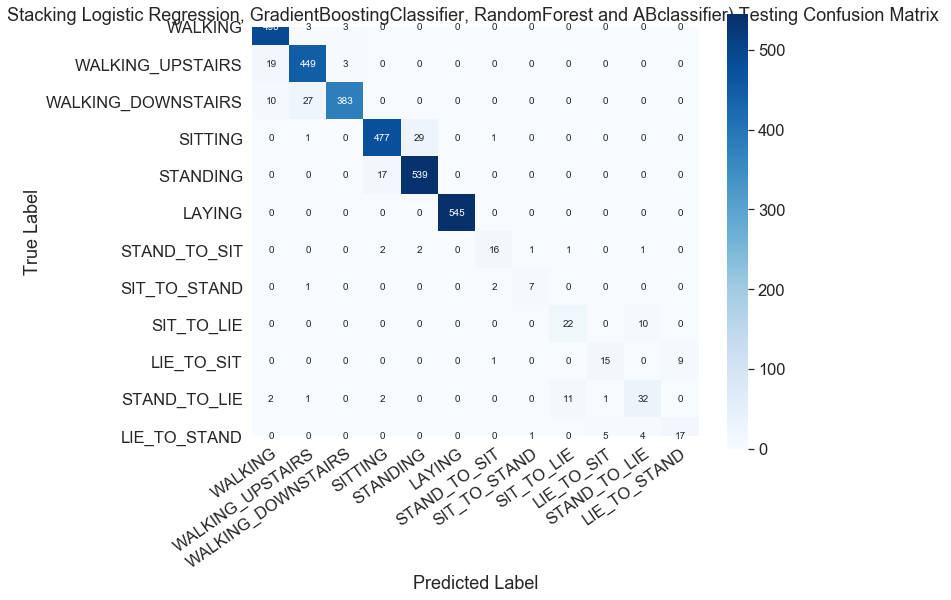


Normalized Confusion matrix (normalized to % of total test data):
[[15.496521    0.09487666  0.09487666  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.6008855  14.199874    0.09487666  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.31625554  0.8538899  12.112587    0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.03162555  0.         15.085389    0.917141    0.
   0.03162555  0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.53763443 17.046173    0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         17.235928
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.06325111  0.06325111  0.
   0.50600886  

In [242]:
# PLotting the confusion matrix of our model
# Classification 
print("classification_report for Stacking Classifiers ")
Stacked_precision_recall_fscore_support  = confusion_matrix_display('Stacking Logistic Regression, GradientBoostingClassifier, RandomForest and ABclassifier)', y_test2, y_pred)
print(' ')

In [243]:
# The r2_score function computes the coefficient of determination, usually denoted as R².
# It represents the proportion of variance (of y) that has been explained by the independent variables in the model. 
# It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted
# by the model, through the proportion of explained variance.
# As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. 
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.
from sklearn.metrics import r2_score
Stack_r2 = r2_score(y_test2, y_pred)
print("r2 score: ", Stack_r2)

r2 score:  0.9491833857191286


In [244]:
# “The Matthews correlation coefficient is used in machine learning as a measure of the quality of 
# binSVC_r2ary (two-class) classifications. It takes into account true and false positives and negatives 
# and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
# https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
from sklearn.metrics import matthews_corrcoef
Stack_mc = matthews_corrcoef(y_test2, y_pred)
print('matthews_corrcoef: ', Stack_mc)

matthews_corrcoef:  0.9367038930002798


In [245]:
# To go further, try xgboost and lightgbm classifiers
# reference: https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/

## Create a Artificial Neural Network Model

In [ ]:
# Some references:
# https://victorzhou.com/blog/keras-neural-network-tutorial/
# https://github.com/UdiBhaskar/Human-Activity-Recognition--Using-Deep-NN/blob/master/Human%20Activity%20Detection.ipynb
# https://github.com/dspanah/Human-Activity-Recognition-Keras-Android/blob/master/notebook/Human-Activity-Recognition-Keras.ipynb
# https://github.com/deadskull7/Human-Activity-Recognition-with-Neural-Network-using-Gyroscopic-and-Accelerometer-variables/blob/master/Human%20Activity%20Recognition%20(97.98%20%25).ipynb

In [ ]:
train = X_train2
test = X_test2

In [ ]:
# Join Activity column to the dataframe (right) 
X_train2['Activity'] = y_train2
# Join Activity column to the dataframe (right) 
X_test2['Activity'] = y_test2

In [ ]:
X_train2.sample()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df.iloc[:,0:562])
scaled_train = scaler.transform(X_train2.iloc[:,0:562])
print(scaled_train)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(test.iloc[:,0:562])
scaled_test = scaler.transform(X_test2.iloc[:,0:562])
print(scaled_test)

In [ ]:
temp = []
for i in X_train2.Activity:
    if i == "WALKING": temp.append(0)
    if i == "WALKING_UPSTAIRS": temp.append(1)
    if i == "WALKING_DOWNSTAIRS": temp.append(2)
    if i == "SITTING": temp.append(3)
    if i == "STANDING": temp.append(4)
    if i == "LAYING": temp.append(5)
    if i == "STAND_TO_SIT": temp.append(6)
    if i == "SIT_TO_STAND": temp.append(7)
    if i == "SIT_TO_LIE": temp.append(8)
    if i == "LIE_TO_SIT": temp.append(9)
    if i == "STAND_TO_LIE": temp.append(10)
    if i == "LIE_TO_STAND": temp.append(11)
        
# df["n_Activity"] = temp

In [ ]:
X_train2

In [ ]:
X_train2.drop(["Activity"], axis = 1 , inplace = True)
X_test2.drop(["Activity"] , axis = 1 , inplace = True)

In [ ]:
X_train2.drop(["subject"], axis = 1 , inplace = True)
X_test2.drop(["subject"] , axis = 1 , inplace = True)

In [ ]:
X_train2

In [ ]:
from keras.utils import to_categorical
y_train2 = to_categorical(df.n_Activity , num_classes=12)
y_test2 = to_categorical(test.n_Activity , num_classes=12)

## One-hot Encoding with Keras
### Categorical labels should be encoded using by using a technique called One-hot Encoding.

In [ ]:
df=pd.DataFrame(y_train2.Y)
df.T

In [ ]:
#Convert integer based labels to categories
labeled_y_train2 = df.replace({ 1: activity_labels2.Activity[0], 2: activity_labels2.Activity[1], 3: activity_labels2.Activity[2], 4: activity_labels2.Activity[3], 5: activity_labels2.Activity[4], 6: activity_labels2.Activity[5], 7: activity_labels2.Activity[6], 8: activity_labels2.Activity[7], 9: activity_labels2.Activity[8], 10: activity_labels2.Activity[9], 11: activity_labels2.Activity[10], 12: activity_labels2.Activity[11]})
labeled_y_train2


Example-

*Before One-hot encoding*

| Class Label | Mapped Integer |
| :---------: | :------------: |
| Walking | 0 |
| WALKING_UPSTAIRS | 1 |
| WALKING_DOWNSTAIRS | 2 |
| SITTING | 3 |
| STANDING | 4 |
| LAYING | 5 |
| STAND_TO_SIT | 6 |
| SIT_TO_STAND | 7 |
| SIT_TO_LIE | 8 |
| LIE_TO_SIT | 9 |
| STAND_TO_LIE | 10 |
| LIE_TO_STAND | 11 |

*After One-hot encoding*

| Class Label | 0 | 1 | 2 | 3 | 4 | 5 |
| :---------: | - | - | - | - | - | - |
| Walking | 1 | 0 | 0 | 0 | 0 | 0 | 1 |
| WALKING_UPSTAIRS | 0 | 1 | 0 | 0 | 0 | 0 |
| WALKING_DOWNSTAIRS | 0 | 0 | 1 | 0 | 0 | 0 |
| SITTING | 0 | 0 | 0 | 1 | 0 | 0 |
| STANDING | 0 | 0 | 0 | 0 | 1 | 0 |
| LAYING | 0 | 0 | 0 | 0 | 0 | 1 |
| STAND_TO_SIT | 1 | 0 | 0 | 0 | 0 | 0 |
| SIT_TO_STAND | 0 | 1 | 0 | 0 | 0 | 0 |
| SIT_TO_LIE | 0 | 0 | 1 | 0 | 0 | 0 |
| LIE_TO_SIT | 0 | 0 | 0 | 1 | 0 | 0 |
| STAND_TO_LIE | 0 | 0 | 0 | 0 | 1 | 0 |
| LIE_TO_STAND | 0 | 0 | 0 | 0 | 0 | 1 |


We will use the `to_categorical()` functions provided by the `keras.utils` module for one-hot encoding the labels.  
For further details, read the documentation [here](https://keras.io/utils/#to_categorical)

In [ ]:
# one hot encode
# reference: https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
a_y_train2 = array(y_train2)
print(a_y_train2)
trainy_encoded = to_categorical(a_y_train2)
print(trainy_encoded)
print('Shape of encoded data:', trainy_encoded.shape)

a_y_test2 = array(y_test2.Y)
print(a_y_test2)
trainy_encoded = to_categorical(a_y_test2)
print(trainy_encoded)
print('Shape of encoded data:', trainy_encoded.shape)



# invert encoding
inverted = argmax(encoded[0])
print(inverted)
one_hot_enc_y_train2 = inverted
np.set_printoptions(edgeitems=3,infstr='inf',
linewidth=75, nanstr='nan', precision=3,
suppress=False, threshold=1000, formatter=None)
print('Shape of inverted labels:', one_hot_enc_y_train2.shape)

In [ ]:
# one hot encode y
trainy = to_categorical(y_train2)
testy = to_categorical(y_test2)

In [ ]:
print(X_train2.shape , y_train2.shape)
print(X_test2.shape , y_test2.shape)

In [ ]:
scaled_train
print(scaled_train.shape , y_train2.shape)
print(scaled_test.shape , y_test2.shape)

## Building the Neural Network Classifier 
### Building , Training, and evaluating using a simple artificial neural network 

In [ ]:
# ref: https://github.com/hardik04021996/Human-Activity-Recognition-using-machine-learning/blob/master/ANN%2Bfor%2BHuman%2BActivity%2BRecognition.ipynb


In [250]:
aX_train2=X_train2.values #converting training data into array
aX_train2

array([[ 0.04357967, -0.00597022, -0.03505434, ..., -0.84155851,
         0.17991281, -0.05171842],
       [ 0.03948004, -0.00213128, -0.02906736, ..., -0.8450924 ,
         0.18026111, -0.04743634],
       [ 0.03997778, -0.00515272, -0.02265071, ..., -0.84923013,
         0.18060956, -0.04227136],
       ...,
       [ 0.03745094, -0.00272442,  0.02100941, ..., -0.77956634,
         0.24912145,  0.04707077],
       [ 0.04401105, -0.00453578, -0.0512422 , ..., -0.78560327,
         0.24640867,  0.03170003],
       [ 0.06895376,  0.00181032, -0.08032343, ..., -0.78369253,
         0.24678499,  0.04298129]])

In [251]:
aX_test2 = X_test2.values #converting test data into array
aX_test2

array([[ 0.0309139 , -0.00892689,  0.04038223, ..., -0.7205591 ,
         0.27677941, -0.05107403],
       [ 0.04254816,  0.00107859, -0.02623642, ..., -0.6986837 ,
         0.28132158, -0.07682459],
       [ 0.0382968 , -0.01166028, -0.0256426 , ..., -0.70335515,
         0.28006162, -0.07230248],
       ...,
       [ 0.06833377,  0.04382217, -0.02413471, ..., -0.65603364,
         0.27445701,  0.18652707],
       [ 0.02301605,  0.03234511, -0.01182959, ..., -0.66038682,
         0.26475922,  0.1928648 ],
       [-0.0108462 , -0.00413392, -0.03767837, ..., -0.66074775,
         0.26391374,  0.19340177]])

### One-hot Encoding with Keras
#### Categorical labels should be encoded using by using a technique called One-hot Encoding

In [252]:
# one hot encode
# reference: https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
one_hot_enc_y_train = onehotencoder.fit_transform(y_train2).toarray()

In [253]:
one_hot_enc_y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [254]:
# verify shape before ANN training.
print(aX_train2.shape)
print(aX_test2.shape)

(7767, 561)
(3162, 561)


In [255]:
# set the input shape
# input_shape=scaled_train.shape[1]

input_dim = 561,

In [256]:
n_nodes_input = 561 # number of input features
num_classes = len(activity_labels2.Activity)       # number of activities
print(num_classes)

12


### defining the artificial neural network model

The data is ready in such a format that Keras will be able to process it. I have decided to create a neural network with 6 hidden layers of Dense connected nodes each. The full structure of our ANN model will be summarized with model summary. After the input layer, a dense layer of 128 nodes is applyed with a ReLU function. The ReLU function is used as activation function within the whole network, while the loss is calculated with the cross entropy function. Next Batch normalization is then applied following the first Dense layer. The next layers are composed of four dense layers of 128, 196, 32
and 12 units. The dense layers are regularized with dropout during the training phase, with a 0.5 probability of keeping each neuron. The Adam optimizer is used as stochastic optimization method. The output layer is composed of 12 units, where 12 corresponds to the number of activities in each group. The sigmoid function will return the most likely class of the input windows in the multi-class classification task.

In [257]:
# reference: https://keras.io/getting-started/sequential-model-guide/
# https://victorzhou.com/blog/keras-neural-network-tutorial/
# https://www.tensorflow.org/tutorials/quickstart/beginner
# https://stackoverflow.com/questions/48674881/keras-expected-3-dimensions-but-got-array-with-shape-dense-model
# https://github.com/UdiBhaskar/Human-Activity-Recognition--Using-Deep-NN

# defining the artificial neural network model
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
model = tf.keras.Sequential()     #sequential is required to initialise the neural network
from keras.layers import Dense, Dropout ,Flatten,  BatchNormalization, Activation 
#Dense is used to build the layers
#Dropout Layer in order to prevent Regularization in the network
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

adam = keras.optimizers.Adam(lr=0.0005)
rmsprop = keras.optimizers.RMSprop(lr=0.001)

# Using the Sequential Model as a sequence of layers
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(768, input_dim= 561, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(.03),   # dp made improvement in accuracy
  tf.keras.layers.Dense(196, activation='relu'),
  # tf.keras.layers.Dropout(.03),   # dp made improvement in accuracy
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
  # tf.keras.layers.Dense(num_classes, activation='softmax')
])
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
            # loss='sparse_categorical_crossentropy',
            # loss='mean_squared_error',
              metrics=['accuracy'])

# also try optimizer='rmsprop'

In [260]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 768)               431616    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               98432     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 196)               25284     
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

###  ANN Model Training & Evaluation

In [ ]:
# Train the model
num_epochs = 40
batch_size = 32

# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='./data/HAPT Data Set/Model_1.weights.best.hdf5', save_best_only=True, verbose=1)

#Fitting the ANN to the training set and training the model for num_epochs 
history = model.fit(aX_train2, one_hot_enc_y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(aX_train2, one_hot_enc_y_train),
                    verbose=1)

In [263]:

pred = model.predict(aX_test2)
print(pred)

[[1.49011612e-07 3.87430191e-07 5.96046448e-08 ... 5.96046448e-08
  0.00000000e+00 4.47034836e-06]
 [0.00000000e+00 8.94069672e-08 5.96046448e-08 ... 8.94069672e-08
  0.00000000e+00 2.38418579e-07]
 [1.78813934e-07 4.76837158e-07 1.78813934e-07 ... 2.08616257e-07
  5.96046448e-08 2.44379044e-06]
 ...
 [1.51991844e-06 9.99612749e-01 0.00000000e+00 ... 0.00000000e+00
  1.22189522e-06 0.00000000e+00]
 [3.02493572e-05 9.99672174e-01 2.08616257e-07 ... 0.00000000e+00
  2.05636024e-06 0.00000000e+00]
 [1.39413446e-01 9.60775495e-01 2.70903111e-05 ... 2.44379044e-06
  1.05947256e-04 3.45706940e-06]]


In [264]:

predictions = []
for i in range(len(pred)):
    predictions.append(pred[i].argmax() + 1)

In [265]:
# get ANN Model accuracy score
from sklearn import metrics
ann_model_1_accuracy_score = metrics.accuracy_score(y_test2, predictions)*100
# print(str(ann_model_1_accuracy_score) + ' %')
print('ANN Model accuracy score: {:.3f} %'.format(ann_model_1_accuracy_score))

ANN Model accuracy score: 89.405 %


### Model - 1 Performance
#### Learning Curve - Model Training loss vs. Validation loss

The performance of this simple ANN is OK. We have validation accuracy of approximately xx%. This could definitely improved, maybe with further hyperparameter tuning and especially with a modified neural network design. Before we go on with the test validation, we will print the learning curve for both the training and validation data set.

Let’s continue with this model and see how it performs against the test data. In our case, we will check the performance against the movements of the users that the model has not yet seen.

In [266]:
accuracy = model.evaluate(X_test2, y_test2, batch_size=batch_size, verbose=0)

ValueError: You are passing a target array of shape (3162, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

In [ ]:
# Loading the model checkpoint that performed the best on the validation set
# model.load_weights('Model_1.weights.best.hdf5')
model.load_weights('./data/HAPT Data Set/Model_1.weights.best.hdf5')
# Testing the model on the Test data
# (loss, accuracy) = model.evaluate(scaled_test, to_categorical(y_test2), batch_size=batch_size, verbose=2)
(loss, accuracy) = model.evaluate(X_train2, to_categorical(y_test2), batch_size=batch_size, verbose=2)

print('ANN Model accuracy on test data: {:.2f}%'.format(accuracy * 100))


ValueError: x and y must have same first dimension, but have shapes (39,) and (40,)

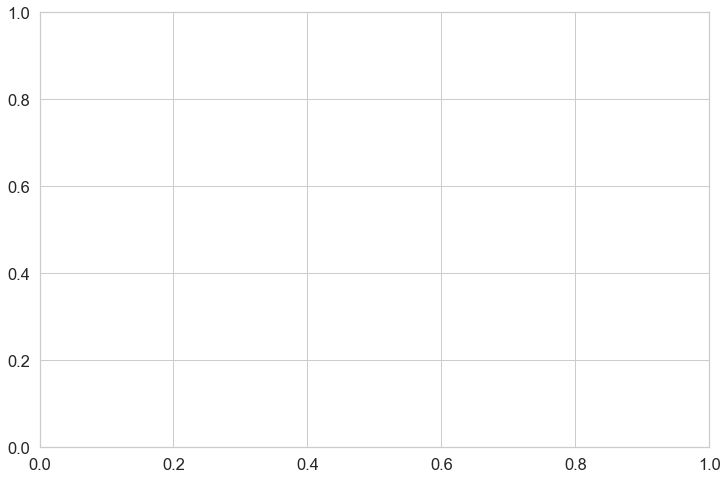

In [268]:
# Making the plot larger
plt.figure(figsize=(12, 8))

loss = history.history['loss']                          # Loss on the training data
val_loss = history.history['val_loss']                  # Loss on the validation data
epochs = range(1, num_epochs)

plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
plt.title("Learning Curve - ANN Model Training loss vs. Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

In [269]:
#### Learning Curve - Model Training Accuracy, and Test Accuracy vs. Model Test loss and Test Loss

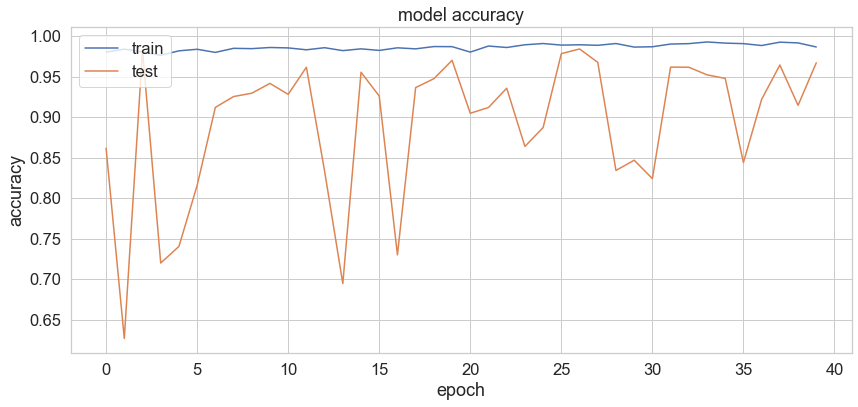

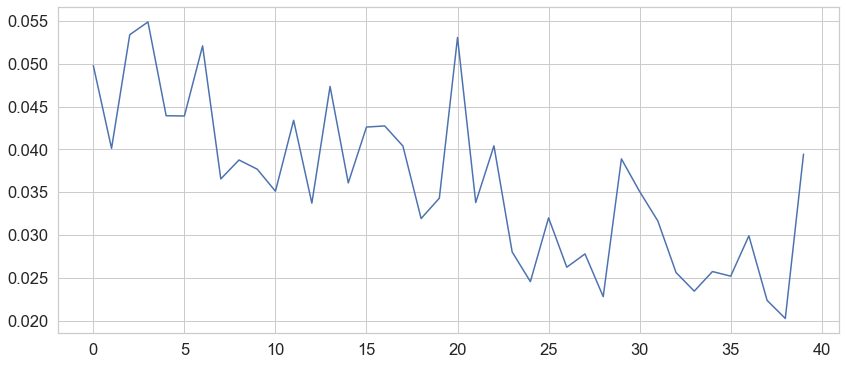

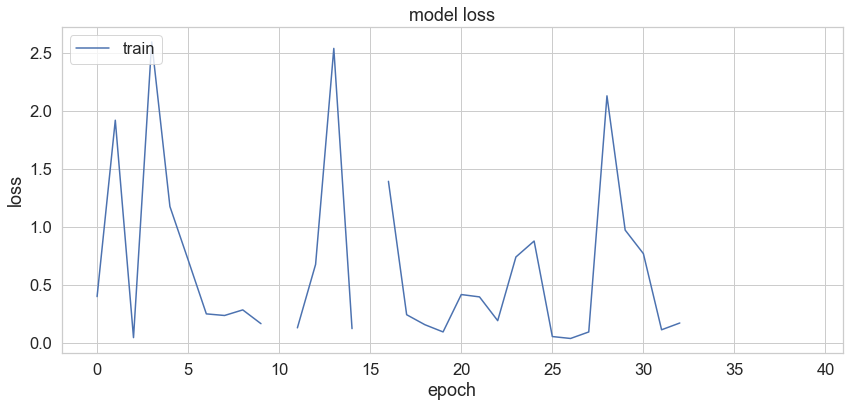

In [278]:
from pylab import rcParams
# reference: https://realpython.com/python-matplotlib-guide/
rcParams['figure.figsize'] = 14, 6
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])

# Confusion Matrix
y_pred_ohe = model.predict(X_test2)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test2, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)

Labels = ['Walking','Walking Upstairs','Walking Downstairs','Sitting','Standing','Laying', 'STAND_TO_SIT','SIT_TO_STAND', 'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND']

plt.figure(figsize=(14, 6))

plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Confusion Matrix


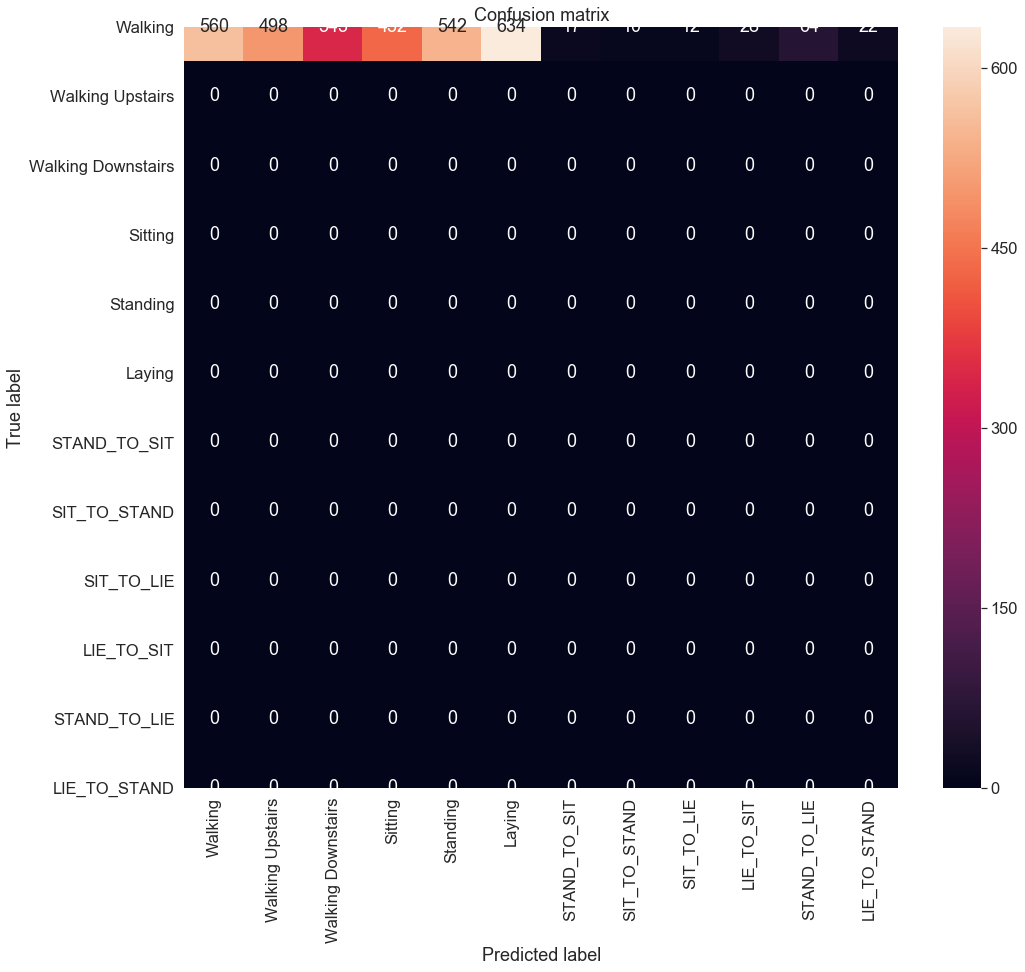

In [279]:
y_pred_ohe = model.predict(X_test2)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test2, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)

Labels = ['Walking','Walking Upstairs','Walking Downstairs','Sitting','Standing','Laying', 'STAND_TO_SIT','SIT_TO_STAND', 'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND']

plt.figure(figsize=(16, 14))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=Labels, yticklabels=Labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [280]:
from sklearn.metrics import confusion_matrix
# model.load_weights('./data/kaggle-dataset/Model_2.weights.best.hdf5')
model.load_weights('./data/HAPT Data Set/Model_1.weights.best.hdf5')
y_pred = model.predict(X_test2)
y_pred = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

OSError: Unable to open file (unable to open file: name = './data/HAPT Data Set/Model_1.weights.best.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

classification_report for ANN


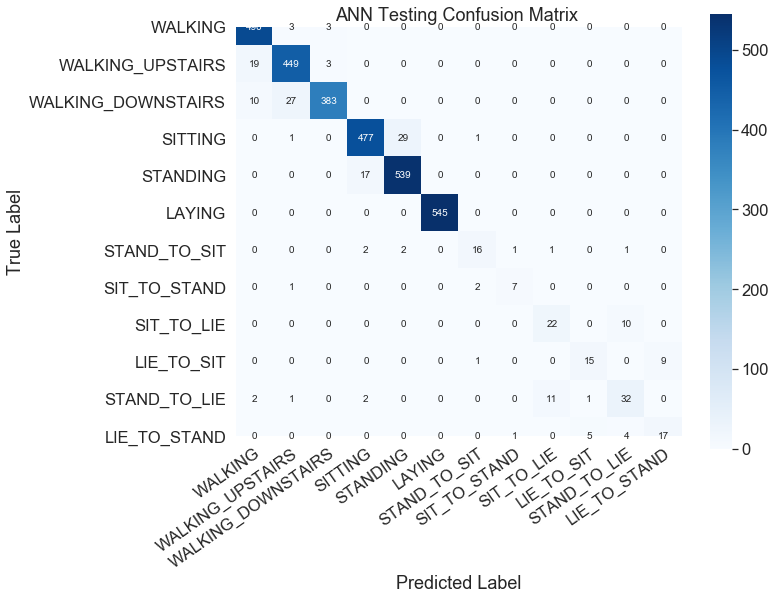


Normalized Confusion matrix (normalized to % of total test data):
[[15.496521    0.09487666  0.09487666  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.6008855  14.199874    0.09487666  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.31625554  0.8538899  12.112587    0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.03162555  0.         15.085389    0.917141    0.
   0.03162555  0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.53763443 17.046173    0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         17.235928
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.06325111  0.06325111  0.
   0.50600886  

'                    precision    recall  f1-score   support\n\n           WALKING       0.94      0.99      0.96       496\n  WALKING_UPSTAIRS       0.93      0.95      0.94       471\nWALKING_DOWNSTAIRS       0.98      0.91      0.95       420\n           SITTING       0.96      0.94      0.95       508\n          STANDING       0.95      0.97      0.96       556\n            LAYING       1.00      1.00      1.00       545\n      STAND_TO_SIT       0.80      0.70      0.74        23\n      SIT_TO_STAND       0.78      0.70      0.74        10\n        SIT_TO_LIE       0.65      0.69      0.67        32\n        LIE_TO_SIT       0.71      0.60      0.65        25\n      STAND_TO_LIE       0.68      0.65      0.67        49\n      LIE_TO_STAND       0.65      0.63      0.64        27\n\n          accuracy                           0.95      3162\n         macro avg       0.84      0.81      0.82      3162\n      weighted avg       0.95      0.95      0.95      3162\n'

In [281]:
# PLotting the confusion matrix of our model
# Classification Report
print("classification_report for ANN")
confusion_matrix_display('ANN', y_test2, y_pred)

In [282]:
from sklearn import metrics
print (str(metrics.accuracy_score(y_test2, y_pred)*100) + ' %')

94.6236559139785 %


In [283]:
from sklearn.metrics import r2_score
ANN_r2 = r2_score(y_test2, y_pred)
print("r2 score: ", ANN_r2)

r2 score:  0.9491833857191286


In [284]:
print('get the data from the following txt files into pandas dataframes') 
print(os.listdir('./data/HAPT Data Set'))

get the data from the following txt files into pandas dataframes
['activity_labels.txt', 'features.txt', 'features_info.txt', 'human_activity_predictions.csv', 'RawData', 'README.txt', 'Test', 'Train']


In [ ]:
# https://github.com/UdiBhaskar/Human-Activity-Recognition--Using-Deep-NN/blob/master/Human%20Activity%20Detection.ipynb

Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening https://www.mdpi.com/1424-8220/18/4/1055/pdf

## Results:

Machine Learning Algorithms Results

In order to evaluate our classifiers, we collect individual precision and recall scores
for every combination of sensors and activities, and we then compute the accuracy and Fscores. A synoptic overview of the results is presented below:

In [ ]:
print('\n                     Accuracy     Error')
print('                     ----------   --------')
print('Logistic Regression : {:.04}%       {:.04}%'.format(log_reg_grid_results['accuracy'] * 100,\
                                                  100-(log_reg_grid_results['accuracy'] * 100)))

print('Linear SVC          : {:.04}%       {:.04}% '.format(lr_svc_grid_results['accuracy'] * 100,\
                                                        100-(lr_svc_grid_results['accuracy'] * 100)))

print('rbf SVM classifier  : {:.04}%      {:.04}% '.format(rbf_svm_grid_results['accuracy'] * 100,\
                                                          100-(rbf_svm_grid_results['accuracy'] * 100)))

print('DecisionTree        : {:.04}%      {:.04}% '.format(dt_grid_results['accuracy'] * 100,\
                                                        100-(dt_grid_results['accuracy'] * 100)))

print('Random Forest       : {:.04}%      {:.04}% '.format(rfc_grid_results['accuracy'] * 100,\
                                                           100-(rfc_grid_results['accuracy'] * 100)))

print('GradientBoosting DT : {:.04}%      {:.04}% '.format(gbc_grid_results['accuracy'] * 100,\
                                                        100-(gbc_grid_results['accuracy'] * 100)))

In [ ]:
# Let's convert this notebook to a README automatically for the GitHub project's title page:
!jupyter nbconvert --to markdown human_activity_dectector.ipynb
!mv human_activity_dectector.md NOTEBOOK.md

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier

# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
    # nonlinear models
    models['KNeighborsClassifier'] = KNeighborsClassifier(n_neighbors=13)
    models['DecisionTreeClassifier'] = DecisionTreeClassifier()
    models['SVC'] = SVC()
    # ensemble models
    models['BaggingClassifier'] = BaggingClassifier(n_estimators=500)
    models['RandomForestClassifier'] = RandomForestClassifier(n_estimators=500)
    models['GradientBoostingClassifier'] = GradientBoostingClassifier(n_estimators=500)
    print('Defined %d models' % len(models))
    return models
 
# evaluate a single model
def evaluate_model(trainX, trainy, testX, testy, model):
    # fit the model
    model.fit(trainX, trainy)
    # make predictions
    yhat = model.predict(testX)
    # evaluate predictions
    accuracy = accuracy_score(testy, yhat)
    return accuracy * 100.0
 
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(trainX, trainy, testX, testy, models):
    results = dict()
    print()
    # print('Accuracy')
    for name, model in models.items():
        # evaluate the model
        results[name] = evaluate_model(trainX, trainy, testX, testy, model)
        # show process
        print('%s,        %.2f' % (name, results[name]))

    return results
 
# print and plot the results
def summarize_results(results, maximize=True):
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,v) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    print()
    print('\nMean Scores')
    for name, score in mean_scores:
        # print('%s, Score=%.2f' % (name, score))
        print('                       ----------   --------')
        print('{:.04},'          ',  {:.03}%'.format(name, score))
        
# get model list
models = define_models()
# evaluate models
results = evaluate_models(X_train2, y_train2, X_test2, y_test2, models)
# summarize results
# summarize_results(results)

Defined 6 models

KNeighborsClassifier,        88.84
DecisionTreeClassifier,        81.37
SVC,        91.81
